![image alt ><](https://i1.sndcdn.com/artworks-000058062617-qqgpfp-t500x500.jpg)

Incrição no Anel:

![Picture](https://upload.wikimedia.org/wikipedia/commons/thumb/2/23/One_Ring_inscription.svg/300px-One_Ring_inscription.svg.png)

Em Inglês:

One ring to rule them all,
   one ring to find them,
One ring to bring them all
   and in the darkness bind them.

# Visualização Computacional - Atividade 2

Nessa atividade, nosso objetivo é identificar o grupo taxonômico de nosso conjunto de dados e adotar um mapeamento visual, confirmando se o paradigma adotado é o mais adequado para a visualização, e também descrever os insights com ela obtidos.

### Conjunto de Dados

Os livros foram retirados do site: https://www.kaggle.com/ashishsinhaiitr/lord-of-the-rings-text. Nosso *corpus* consiste em três arquivos `.txt`, cada um contendo um volume da trilogia *The Lord of the Rings*.

Na primeira etapa deste projeto, realizamos um pré-processamento, de forma a remover pontuação, stopwords, e lematizar nosso dataset. Esse processo foi ilustrado com o auxílio de wordclouds.

Livro 1 antes do pré-processamento:

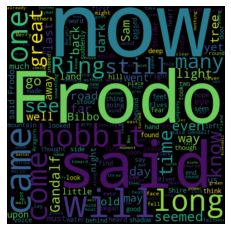



Livro 1 após o pré-processamento:

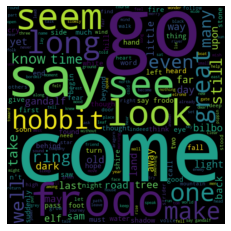

Como podemos ver acima, por conta do alto volume de ocorrência de verbos, o pré-processamento utilizado nos forneceu indícios de que precisávamos então encontrar outra maneira para tentar filtrar o ruído e extrair a informação relevante de nosso corpus.  

## Adoção de um paradigma de mapeamento visual

Primeiramente, adotemos mais um passo em nosso pré-processamento: a remoção das palavras mais comuns na Língua Inglesa, com o auxílio de um arquivo com mais de 4000 palavras. Com isso, nosso objetivo é minimizar o erro no procedimento de reconhecimento de entidade, que a seguir realizaremos.



In [ ]:
import nltk
nltk.download('punkt')

# instalando o afinn
!pip install afinn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# carregando as bibliotecas exigidas

# exibindo os graficos inline no jupyter
%matplotlib inline

import codecs
import requests
import os
import spacy
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from afinn import Afinn
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def flatten(input_list):
    '''
    A function to flatten complex list.
    :param input_list: The list to be flatten
    :return: the flattened list.
    '''

    flat_list = []
    for i in input_list:
        if type(i) == list:
            flat_list += flatten(i)
        else:
            flat_list += [i]

    return flat_list


In [ ]:
def common_words():
    '''
    Lê as common words de um arquivo externo 
    :path: Onde as common words estão armazenadas.
    :return: Um conjunto das palavras comuns.
    '''
    path = "https://raw.githubusercontent.com/chicodias/character-network/master/common_words.txt"
    response = requests.get(path)
    words = response.text
    words = json.loads(words)

    return set(words)

In [ ]:
# Lendo os livros
def read_novel(novel_list):
    '''
    Função que lê os livros de um dado url
    :return: o texto do livro.
    
    '''

    book_list = novel_list
    book_list = [i for i in book_list]
    novel = ''
    for i in book_list:
        response = requests.get(i)
        words = response.text
        data = words.replace('\r', ' ').replace('\n', ' ').replace("\'", "'")
        novel += ' ' + data

    return novel


#### O Modelo de Reconhecimento de Entidade Mencionada (NER)

Sem nenhum conhecimento prévio dos romances, o **modelo de reconhecimento de entidade mencionada** (Named-entity recognition ou NER) encontrará os personagens que fazem parte deles. Neste projeto, utilizamos o classificador pré treinado **Spacy NER**. Por conta do alto poder de processamento exigido por este módulo, processaremos as frases uma por vez, ao invés de todo o livro em uma tacada só.

Para cada frase, identificamos as entidades nela mencionadas e fazemos alguns processamentos. Um deles é dividir o nome em palavras únicas, se este for constituído por mais de uma palavra. Assim, "Bilbo" e "Bilbo Baggins" referirão-se a mesma entidade, de forma a contabilizar a ocorrência de um personagem na frase de forma mais apurada.

Após todas as palavras únicas de nome terem sido criadas, filtramos os nomes que aparecem na lista de palavras comuns, pois algumas delas podem vir a ser contadas como entidades equivocadamente. E então, agregamos os nomes de cada frase, e filtramos os nomes cujo número de ocorrência seja menor que um certo limiar definido, a fim de evitar enganos de reconhecimento raros.


In [ ]:
def name_entity_recognition(sentence):
    '''
    Uma função que recupera as entidades em uma frase.
    :param sentence: a frase para pegar os nomes.
    :return: uma lista de entidades mencionadas na frase
    '''

    doc = nlp(sentence)
    # retrieve person and organization's name from the sentence
    name_entity = [x for x in doc.ents if x.label_ in ['PERSON', 'ORG']]
    # convert all names to lowercase and remove 's in names
    name_entity = [str(x).lower().replace("'s","") for x in name_entity]
    # split names into single words ('Harry Potter' -> ['Harry', 'Potter'])
    name_entity = [x.split(' ') for x in name_entity]
    # flatten the name list
    name_entity = flatten(name_entity)
    # remove name words that are less than 3 letters to raise recognition accuracy
    name_entity = [x for x in name_entity if len(x) >= 3]
    # remove name words that are in the set of 4000 common words
    name_entity = [x for x in name_entity if x not in words]

    return name_entity


In [ ]:

def iterative_NER(sentence_list, threshold_rate=0.0005):
    '''
    Uma função para executar o NER iterativamente. O propósito dessa função é reconhecer
    todos os nomes importantes enquanto reduz os erros de reconhecimento.
    :param sentence_list: lista de frases do livro
    :param threshold_rate: o limiar de frequencia por frase; podemos remover uma palavra
    devido a erros de reconhecimento
    :return: conjunto de nomes na trama.
    '''

    output = []
    for i in sentence_list:
        name_list = name_entity_recognition(i)
        if name_list != []:
            output.append(name_list)
    output = flatten(output)
    from collections import Counter
    output = Counter(output)
    output = [x for x in output if output[x] >= threshold_rate * len(sentence_list)]

    return output


#### Relevância dos personagens

A partir da lista preliminar de personagens que obtivemos, calculamos a relevância de cada personagem, ou, mais especificamente, a frequência de ocorrência de cada entidade. Fazemos isso com auxílio da função de processamento textual do Scikit-Learn `CountVectorizer`.

Dessa maneira, pudemos selecionar somente os personagens que fossem mais relevantes para nossa análise. Neste trabalho, a função `top_names` retorna os 25 nomes mais mencionados durante a trama.

In [ ]:
def top_names(name_list, novel, top_num=25):
    '''
    A function to return the top names in a novel and their frequencies.
    :param name_list: the non-duplicate list of names of a novel.
    :param novel: the novel text.
    :param top_num: the number of names the function finally output.
    :return: the list of top names and the list of top names' frequency.
    '''

    vect = CountVectorizer(vocabulary=name_list, stop_words='english')
    name_frequency = vect.fit_transform([novel.lower()])
    name_frequency = pd.DataFrame(name_frequency.toarray(), columns=vect.get_feature_names())
    name_frequency = name_frequency.T
    name_frequency = name_frequency.sort_values(by=0, ascending=False)
    name_frequency = name_frequency[0:top_num]
    names = list(name_frequency.index)
    name_frequency = list(name_frequency[0])

    return name_frequency, names


#### Matriz de Co-ocorrência

Neste projeto, tomamos a definição mais simples de co-ocorrência: dois personagens são **co-ocorrentes** se aparecem juntos na mesma frase. É interessante salientar que existem outras definições possíveis, baseadas em parágrafos, número de palavras ou em diversas frases.

Para calcular a co-ocorrência, primeiro é necessário uma **matriz binária de co-ocorrência**, que nos dá a informação de quando um nome ocorre numa dada sentença, novamente com auxílio da função `CountVectorizer`.

Assim, a matrix de co-ocorrência é igual ao produto cruzado entre a matriz de ocorrência e sua transposta. Como a co-ocorrência é mutualmente iterativa, temos que a matriz de co-ocorrência é *triangular simétrica*, conforme ilustrado abaixo.

$$ X_{coocor} = X_{ocor}^T \cdot X_{ocor} $$

![image.png](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABGIAAADPCAYAAAC+/ne8AAAABHNCSVQICAgIfAhkiAAAIABJREFUeF7t3Qt8FFW+J/Bf3pIorEkg5p0Al8fouiKuvFGE4eJnVOSD4IyCXHQVFCS8jNEB
/SDuBXkj4IiKKEQUEC8gM+oMXkYgCE6MrOMsb0IIIUYCu+gkLAlJtk6/kk660+lHVZ3T/evPJ+NQVX3O/3xPVXX1v6vOCWvQXuCLAhSgAAUoQAEKUIACFKAABShAAQpQQHeBcN1rYAUUoAAFKEABClCAAhSgAAUoQAEKUIACFgEmYrgjUIACFKAABShAAQpQgAIUoAAFKEABgwQiDaqH1VCAAhSQSuDP+3/CTxevShVTW4P59cBO+F9HLjP+toIFeLtg8E9KiAmwCoujAAUoQAEKUIACFGirABMxbZXidhSgQFAJ7Nn7E47/47KSbbqlR3swfvO6Lhj8mYgxb/9hzRSgAAUoQAEKUICPJnEfoAAFKEABClCAAhSgAAUoQAEKUIACBgkwEWMQNKuhAAUoQAEKUIACFKAABShAAQpQgAJMxHAfoAAFKEABClCAAhSgAAUoQAEKUIACBgkwEWMQNKuhAAUoQAEKUIACFKAABShAAQpQgAJMxHAfoAAFKEABClCAAhSgAAUoQAEKUIACBgkwEWMQNKuhAAUoQAEKUIACFKAABShAAQpQgAJMxHAfoAAFKEABClCAAhSgAAUoQAEKUIACBgkwEWMQNKuhAAUoQAEKUIACFKAABShAAQpQgAJMxHAfoAAFKEABClCAAhSgAAUoQAEKUIACBglEGlQPq6EABShAAUUFIq7Gofej3fH8qHbWFlSUYFbOOZyJkL9B19I7YsbMdNzdyRa7FnJJxUUUbj+LTXurpW+A6vFLD8wAKUABClCAAhSggAkCTMSYgM4qKUABCqgiIBIBOTndMDhZlYgb46zq3xOfT4lvEXhmUgIyJyVgYHIRntl8pcV6WRbEj70db49sTCDZ47LH3/fOo5i25KIs4TIOClCAAhSgAAUoQIE2CvDRpDZCcTMKUIACoSYgEgE7FtqSMGVVOKUQQPQviZhpS8I0oBrb1n6HaS8exjN/OOdoR6cHeuCx9AYpW9WQnIk8exKmvBI7Z1vjf3b1JUf8qb164IXB9VLGz6AoQAEKUIACFKAABdwLMBHj3oZrKEABCoSsgHgcqX/fdhBJjIN//A6/e7oxgaECyvVPZGC4LdBv135reQyprKQKFftLMGXNJcuaMMSib/9YKZuTMCgBXbTIhP+OlUfxfrk1/vNfH3HELwJPT46TMn4GRQEKUIACFKAABSjgXoCJGPc2XEMBClAgpAUiK0qxYk4RFm+SfyyV5h2VmgHLnSP1qMTBv4Q5rY4trnbcVZKU0vLRn+ZlGf1vkQSzxx9WcQF7z7iP3+jYWB8FKEABClCAAhSggP8CHCPGf0OWQAEKUEBagabjpBSu3Yf5xUlOg9eKOy6++fQstnxw0Wnw3bqYKmx/rUprl3MSwOiG+hr/35cUIdcebIx5bfAlfmHvFH+zQZGrs2Mtd8uIV2m56CP+pmL0fsn6KEABClCAAhSggD8CTMT4o8f3UoACFJBcwHr3R7zli3t9UiaWTcpwfIkXoYvHc/rc3wN9ko9g9HLrIzsyNUmP+Hv9Ns1hUPhtpdZc/RIZgY4/aWAmZj1tG4BYm73qwz1a7ArMXiXTPiVbLBWVV1F+8f/JFlab4klOuM6yHeNvE1fANwoG/6TEmIC7sEC5BWpq6vG/i3+RO0g30cVEhqNLehzjd+Oj9+Jg8O/Z5QYHkyMRk7+jVG873cofNzIdjF83Xo8F098jka4bCH++KNAWgTsf1J7X0QZ+XbHyHE5r39//2T8D795n/VLfcEemNnDtRWwoNe/uEU9tCET8Kf16Yu4dtpoMTmT4Gn/z2ZPEXUxl353Fstec72Ly5Mf1cgr8peAn/MeWs3IG5yGqUWO1c4r2YvweoHRaHQz+vIbRaeeQuNj/83Mt5r/yg8QRug/txqQY/M8X/yvjd0+k65pg8H9nmf0iFHAkYlT9EBW9LU7ijF/X/b7VwunfKo/uK3kRoztx0FQgxkt549mj2Gd/VKfkCObfNMCSmBB3xqRmazMISZyI8Td+kYRZNdWWeNKSGTuXl2qPYxmXePI3/qY7Ylh9LNK6VuJMsXHxB82BwIZQgAIUoAAFKEABkwX4aJLJHcDqKUABChglEF54AXuajZdScEh7HOkO26MuRgXiYz3+xC/uKlllmw5a3FGyM6/I8Lt/fI3/8sZjmHbIipbSNwNjHtAeNeudgZzesYh66GiLPvWRl2+jAAUoQAEKUIACFDBIQL8H4w1qAKuhAAUoQIG2CVScv9K2DSXdytf4nR7tEY9maTNBmfEIlq/xi8F7xdTb4u9vm4/gudnWqcTDkYipeQmS9hbDogAFKEABClCAAhRwJ8BEjDsZLqcABShAAeUFnJIw2pgws2Ycw37FH+eJPFOJvRW2rkmPRVad8t3EBlCAAhSgAAUoQIGQEuCjSSHV3WwsBShAgdAREFNHb7M9jgSRhMk55zRFt6wSDcmZmJabgLs7tUPFziI8s1ntO5lkdWZcFKAABShAAQpQwCwB3hFjljzrpQAFKEAB3QSif0nEzCmN0zyrkoQRIDHHq1CjJWHEK6lPQos7Xq5lJWJwkm50LJgCFKAABShAAQpQQGcB3hGjMzCLpwAFKKCqQGpmnCP0iGaPv6RnxaHWlsoXY5fI9vrVS90xXAtKDMxbtO0SajvHIdVFkPWRVSg/5WKFiYtqbqjE1h0ZGC7u5knKxNLlcY4px6+lJ2LW02noYouv4hCnsDaxq1g1BShAAQpQgAIU8EmAiRif2PgmClCAAsEtIB7red1+R0nzpmrJgekLMx1LC9fuw4K98txgGXE1Dmnp1vDEtNy9n+mF3s3bYPu3ZUppCWceEjMlre97GyaKO1+SEzXvxJYtKDzCx5ZaqnAJBShAAQpQgAIUkF5Anitn6akYIAUoQAEKUMAYATFT0mdTDuPZ1Zdwrsy5zpKKi9i29juMXq5NPc4XBShAAQpQgAIUoIByArwjRrkuY8AUoAAF2i4QVl6C3EdL3L4h7sARjD5gX92Ym3de7vbtthX65fR9iV8kMXbNLMAuT2Hb18eEtXVLr7fzJX57JaId578+gpyvva6Wb6BA0AqIO956P9odz4+yjqOk0kDc19I7YsbMdMtA3PaXSKwWbj+LTXurpe8z1eOXHpgBUsCFAM95LlAMWqT3OY+JmDZ0JA+ANiDptIneB4BOYbssVsyEsniJdWwHMW7FzrwibCjV7wugyyC4kAIUoAAFKKCogLgmyMnphsHJ6jVAPO75uYvHPTOTEpA5KQEDk+WeIS1+7O142z4LXRN+e/x97zyKaUsuqtcxjJgCEgvwnGde5xhxzmMixkP/8gDwAKTjaiMOAB3DdypaJPPufa5xgE2j6mU9FKAABShAgWAQcLomKKvCqdQ4x6DVsrdPzOI2yZaEET/EfLL2GL4qCUPTwbc7PdADjx2Q8wca8UNSnj0JU16JnUtLsTs6DA0pGZg+Nd7SD6m9euCFwXKNFyb7fsH4KNCaAM95renou86oc55+95Pr62NI6eIA2LHQ9suL+NA3pNbAVNJ06lbxoS/GE5j24mE884dzjnZYPvTTGwJTYYBLaXEAzLbGL8ZLsPeD9UO/PsA161Pcz0MyrINu6lM8S6UABShAAQoErYD4MaN/33aWWdAO/vE7/O7pxmsZFRp9/RPaLGi2QL9d+63lMSQx21zF/hJMWWMd60kMLN63f6yUzUkYlGBJtgj/HSuP4v1ya/zi0Ul7/CLw9OTGmfakbAiDooAiAjznmdtRRp3zmIhx0888ANzAGLTYqAPAiObYk2LiAmbrdt62a4Q566AABShAgeASiKwoxYo5RVi8Sf6xVJrLp2bA8iOSmKXt4F+cH0mOLa52/MCUlNI4dkzzMsz6t7getscfVnEBe8+4j9+sGFkvBYJRgOc8c3rVyHMeH01qpY8tB8CqEuwvDkO09kuFSi/7h2a2/UM/pjF664e+9VZS64f+Fama1vQA6GL/0I9wHb9UgbsJ5lcvdbf+ElZYgnVlSRjjZjsupgAFKEABCgSzQNNxUsS09/OLk5wGrxU/WHzz6Vls+eAizjT53BcDV29/rUqjMXdcNV/j//uSIuTaO1bHwcE97Tu+xC/sneJv0i+ivursWMcjYqXloo/4G6+nfuD60BHw5ZgTOjznBWYf8cXfyHNeSCZiOvyuJ35/nzURYelm7bGjg4ePO/3KIssB4Go3bEv8snzo+xK/kQeAq/g8LWuLv70M8YjVI3dYfwV7Y6F2N8yQJE/Fcz0FKEABClAgKAWa/hBUn5SJZZMynMZ5EY/n9Lm/B/oka7O5STg9ux7x9/pt4/hxhd9Wav2uXyIj0PEnDczErKfjrftqRQk+3KPF3ixRE5Q7MhtFgTYKBPqYa2O1AdtMj/h5zmvsnpBLxFgGPrrPduunloA5hzikaQO+9U3thTfq5B6xXnRbIOI38gBofibwN36zP/S9ib/pAL0VO89ij4m/gjXvB/6bAhSgAAUoYKbAnQ9qz+toA7+uWHkOp7Xv7//sn4F3tR/JxKvhjkxtDLuLUs8sGIj4U/r1xFztxxrLy+BEhq/xN59IQdzFVPbdWSx7zfkuJlur+B8KUMAm4OsxJwtgIOLnOc+5N0MqESPG6hhjG/W9Ymdj0sX+oXKlXyKyNpU63Q4ry84v4ghE/GYeAL7GL8uHvrfxdxjf3TpAr3ZxtWiT9vgXfyWS6XBiLBSgAAUoYKKAGC/ljWePYp/9R4qSI5h/0wBLYkLcGZOarU0mUGruo0it8fgbv7geW6XNOCReIpmxc7m4/jSuvf7G39QmrD4WaV0rcUZ7lJ8vClDAtUAgjznXNei71N/4ec5r2T8hlYhp2XzrkktbijB6i22tgl+W2xq/2QdAIP1l+tB35d80aVO4/ax2caXfrcbuXLm8dYEFL97S+gaSr73txQ6SR9h6eIy/dR+upUCwC4QXXmhxp2jBIW0GoTtsj7pIDuBP/OIHplW2HwYtSZg846et9jX+yxuPYdoha+ek9M3AmAe0R/17ZyCndyyiHjraok8l70aGRwHDBHw95gwL0ENF/sTPc55r3JD9diimbs79bQKSxXx8Cr68jd9yADT95cWED/2mzN7Eb/nQ16beFn8Ld17Cae2XshTxof9qDwy5as70257ibxyg9wgW7A3Zw0zBI4shU4ACFKCAEQIV5+WaKMDbNvsav9NdvuLRLG0mqA0m3Pnja/xiHD8x9bb4+9vmI3hutnUq8XAkYmpegreM3J4CISPg6zEnC5Cv8fOc574HQ+obYs0NlVi2Rvu1RXvZB4Rb/coAfPxBL0tSJqvOPZQMa3yNX5YDwNf4ZfnQb2v8YoRucWu1+JVrx8ecrlqGY4cxUIACFKAABcwWcLoe0x5bnjXjmGVmTpVfkWcqsbfC1oL0WOmvpVW2ZuwUUE2A57zWeyzkHk2KO3AEI0s74uEx6ejTu51ltH7HKP13ah+KOeekHSNGdKW38bc8AET7zPvQ9zZ+V7uv9UNfm2VATEBk+dC/ZFiftSX+n9Osg0GL/WrkwoEY6aIRTusK5ZwdwkXYXEQBClCAAhSggA8C4keabbbHkcTAvLJfb9qbKGZ/nJabgLs7tUPT8RV9IOBbKECBEBLgOc9zZ4dcIkaQRJZewLZl2p/2/6+ld9Q+DLthcLJ2B0NSRwzO0gZLM+EWUc9d1bhFW+OX9QDwFH/xtSypP/Q9xb/Lm87ktqYJvPDvP+D4Py6bVr8/Fc996RZkJNTiak2NP8WY9t6ExET88+efGb9JPSD8o6OjTaqd1VIg9ATEuHGTpjRO86xKEkb0VMzxKtR0SrN0WlIf7e7xTc4/WF7LSsRg8cMYXxSgAAVsAjzntW1XCMlETFMa8aV6xVJtdP4l2h0WCozS37xb3cWvygHgKv6YP6rzoe8q/qYD2TXvr4aUDMtYPeKxpU/WHsNXJWGIOl3FGZWaQ/HfFKAABShAgSYCqZlxjn9FNHuUPD0rDrW2h+3F2CWyvezjxonP/qJtl1DbOQ6pLoKsj6xC+SkXK0xcJB7L3rojA8PF3TxJmVi6PM4x5fi19ETMelpcP1tfFYc4hbWJXcWqg0yA5zxzOtTIc15IJWLErEHPj4pHWqTzLaGpWbGWDxHxAVnW5Fld2Q4Ab+KX8UO/rfEbeQB4c4i3NX7rmDauS65qcuUVWawNdifuvlJwpi7XreNSClCAAhSgQOAFxB2+r9vvKGlevJYcmL4w07G0cO0+qQbJj7gah7R0a3jiseTez/RC7+ZtsP3bMj2shDMPiR+Y1ve9DRPFnS/JiZp3YssWaI9ZP7NZ7QGYWzaKSyhgjgDPeea422s16pwXUomYsjPVuJoqbg3VMvofZeJseTVqk61JGAEfVljiGLlexgOgrfHL+qHf1vhFXxh1AHhzmHsTvzflclsKUIACFKAABSggq4D4gemzKYdRdHeG9QfNJj8qlVRcROH2s9i0t1rW8BkXBShAAa8EjDrnhVQiJqy8BDPzqjFjZrpl0LEMLQljeZVV4VBRKbZ8oM2oJPHdCaEUv1EHgDdHper+3rSV21KAAhSgAAUCLSA+R3MfLXFbrBgQf/QB++rGiT2dl7t9u22FfhOC+hK/uJ7ZNbMAbR4/Lka/CRV8id+uLdpx/usjyPnakz/XU4ACdgFfjzme8wKzD/nqL2o34pwXUokYgSrG9Fg1Q/tz1b9NkjCyHADNw2xL/DJ96PsSv/09RhwAzePz9O+2+LdWhvN+pd/FVmsxcB0FKEABClCAAhSgAAUoQAEKmCeg388G5rWJNVOAAhSgAAUoQAEKUIACFKAABShAASkFmIiRslsYFAUoQAEKUIACFKAABShAAQpQgALBKMBETDD2KttEAQpQgAIUoAAFKEABClCAAhSggJQCTMRI2S0MigIUUFlAzFx250O3Y9sHA6x/y9KQVWd+i+qiT+Ov7z6HMampeHjJGfMD8iKC8JLdeOeFkZbYU2x/Y4fn4cvj6oy1pLK/F13FTSlAAQpQgAIUoAAFPAgwEeMBiKspQAEKeCNwLb0jpq66TZvis503b9N9W5HImHP/IDwydxMKdK8tsBXUxu3Gi/0nYPHhnhi2rgAF+/dj76ENGN77CKYPGYVVJ+X/KFPZP7C9ydIoQAEKUIACFKAABUJu1iR2OQUoQAG9BOLH3o63R9oSMGVVOJUahy56VeZFuWVrZ2H6Kx/h+1vHI3drV1SOeRknvHi/2ZsenDoB+zAPO//8JLrXNdjCyUbXBUPRvT4Vc+56C8N/bLrO7Iid61fdXy5NRkMBClCAAhSgAAXUF5D/Z0T1jdkCClAgBATE40j9+7ZDA6px8I/f4XdPn8MpCdotHof54kSE5U6SY58txJRfZ0kQlRchnH8Tr+cD/dY81SQJ0/j+QTlz0QkvY/02OR9RUt7fi67iphSgAAUoQAEKUIACbRPgHTFtc+JWFKAABTwKRFaUYsWqEuwvDkM0Yj1ub8QGETWd8fiSRUZUpUsdpZ/twHmMx7gxWvG1LauoyxqO39w2H+98+iXw4JCWG5i8RHV/k/lCovpfD+yEW3q0V7KtyQnXWeJm/OZ0n/L+idb9xxw91mqWwI3/JQpzX7rFrOr9qjcmMhw3tmf8fiH68eZg8G/afEciRgwqqfKL8Zvbe/Q315+16yvQ4Xc98fv74hsfM9IeOzp4+DgWb6p2VFwXU4Xtr1Vp/5bzzgx9hfQr/czx7xGJ0ehRb38kybkukejool3PReSfwrGIe1zeNaNfdCyZAv4LJCXEQPyp/EpKZPxm9p/q/mbasW7jBaK1ZMZt3TsYX3EAa2T8AcT0oSjV/e1N5qNJPnQ+30IBCoSOgBj35V17EkZLwJwr09qujf3S9ze98MbDcg3IG2y9Ih7rOfUDUDeiS6sJlqxut+IaTuJoOJNgwbYPsD0UoAAFKEABClAgGAX4aFIw9irbRAEKBEQg+pdEjLENvluxswjPbL5iKdc+KO+VfonI2lSKMxEBqY6FUIACFKAABShAAQpQgAIhIMBETAh0MptIAQoEVuDSliKM3mIrk0mYwOKyNAqEmMCf9/+EPXt/UrLVQ+7qhEG334ArVeKxTPVe7eLiLEEzfnP6Tvi3a8c7S83RN6/Wiz/XYMnq4+YF4EfN7W+MwvOT/gX/99IlP0ox763hkZFo37494zepC8LDw/Ff4uMdtTsSMaMfLTApJP+rFeOTlJ8/739BJpWQnJLC+E2yF9UGg7+JfCFTdacHeiA37Cw2/u0iymWYDilk5NlQCgS3wE8Xr+L4Py4r2cibb+6AurpYXK2pUTL+6Ousg8UyfnO6z+5vTu2s1SyBazUNyp7zbkyKQUNDg7LnvMi6OsZv1o6v1RsZ4fzrLceIMbEzWDUFKCC3QM0NlVi2xvqrR5g2C1Kf+3tg9SsD8PEHvZD72wRk1ckdv+rROQbi/VwMxOt+/BfrgL5d3Q7oq7oD46cABShAAQpQgAIUCC4BJmKCqz/ZGgpQIMACcQeOYGTecWz69grsN8LYkzJLV6YxGRNgbxZHAQpQgAIUoAAFKECBYBdgIibYe5jtowAF/BaILL2AbcuKkKs9wimSMnvLrUU2JHXE4CzX0yr7XSkLsAh4mhGpNm43vsgHbpoxrNWZlchJAQpQgAIUoAAFKEABWQSYiJGlJxgHBSighIBIyqxYes5yd4y4MyY1m4kYPTsu/d6RSMFGfL3VdS1RJ07imLYqu2tn1xtwKQUoQAEKUIACFKAABSQTYCJGsg5hOBSggDwCKf16YuWiAdrdMM6PIKVmxaKLFmYDqlFW3Dh2SWpmHOx/N/V0bkd6VuM6eVqoQCQpkzFtHLBvSi52RDl/ZNVFn8Z7T87HT5iHiaOZEFOgNxkiBShAAQpQgAIUoIAmwOmruRtQgAIUcCNQdqYaV1PFNHOZWPpRJs6WV6M22ZqEEW8JKyzBhlJrIqaqf0+8PqVxSjqnIpMyMX1hpmNR4dp9WLDXuDx4cXGxo+66KGu8l+OKUVzcmLzIzs52o2D+4r6r38eQ/AnIHQb8mDMZw7s3oC7qNNblPIZdh/vgqa+e0h5Lqjc/UDcRqO7vpllcTAEKUIACFKAABSjgowATMT7C8W0UoEDwC4SVl2BmXjVmzEzH3Z3aIUNLwlheZVU4VFSKLR9oMyo5z0QnH8r5N5E7cD4Kmkf26jgMeNW6MAEimbEdz3aVM5kRVTUM8y7sw4hp07DyiQHa/S/WV9+x87BiwZMYKmncliiDwL/5rsN/U4ACFKAABShAAQr4J8BEjH9+fDcFKBDkAmJMmFUztD9X7WyShBGzK40+4GojV8uMuxsG2qM9W8smuwqi2TI5kzD2IMVU1gOX7NL+mjdF8keSgsS/uTr/ra5AxNU49H60O54f1c7aiIoSzMo5hzMGJpXDS3Yjb+oavFf0jQNy4M3jMWn1axjaTfJj2haxeDRy35t/wJq5mxA+owCbZ2cps1MEg78y2AzUdAFZznlvvbkKX2wodPwwptI5T5wzGH/gd2UDvw00Bi8OiDsfuh3bPtDGXhB/zcZfCHwzXZcoPkT/+u5zGJOaioeXnHG9kaRLxQHxzgsjLbGn2P7GDs/Dl8cbx6uQNHRLWKrHL9qg8v4j877B2ChAAQpQQB+Ba+kdMXXVbY1JGH2qabXUqK9m4Kb+E3Dyane8e2A/Cvbvx95DGzC89xGMH5KCvO2mXJq2GnPzleIaZs79g/CIloRpcbdh840l+3cw+EtGynAkFpDhnCdmd3xRO+ctPtwTw9YVOJ3zpg8ZhVUn5T7nMX79dnDD74gRB0ROTjcMTtavUW0pWXyIvjBzAt4/aN16UFveJMk24oCYpx3QW28dj5nrVmKRbbyEv655HeKAlvkRA0GoevyiDSrvP5LsxgyDAhSgAAUMFIgfezveHmm7C0Z7vPJUapxl0HEjX+Lzf84jW9B5RD62rBvSpOpsdF0wFN3rU5EnBuYeswgja+W8S69s7SxMf+UjfK9dg+Vu7YrKMS/jhJGIftQVDP5+NJ9vDTEBGc55gvzg1AnYpz1UvfPPT2rj2dnv+Gs858256y0M/7HpOrk6ivHr1x+GpuDEAbFjoS0JIy4C9GtXqyWLD9HRWiLjk2rxIToPj7e6tXwrGw+I1zBpRBbEIJtd04bifyzYgTfGHcLH2gF9LELeO2NUj1/1/Ue+PZoRUYACFKCAngLiTuT+fdtZZno7+Mfv8Lunz5lyDRb7pz9ihzYm1cMvDHXZ3EE5c1udrt7lmwxcKO6E/eJEhOVX7WOfLcSUX2cZWLv/Vanu778ASwgVAVnOeWKcuNfzgX5rxKQCLR+7FOe8TngZ67dJ+r2N8et6yBiWiJHlgFD9Q5QHtK7Hg8fCld9/PLaQG1CAAhSgQDAKRFaUYsWcIizeVG1a82rvWo6/l30i7cDgnmDEWFWPL1lk+RFMxZfq/iqaM2bzBGQ455V+tgPnMR79xrh2qMsajt/cBuz/9EvXG5i8lPHr2wGGPppkOSBWlWB/cRiiYZt9RN/2tSjd/iHaYoUiC+wHxDhxQNe2DNp6QM/HO+KAfrDpbb8ttzVjierxq77/mNHnrJMCFKAABQIjUNW/Jz6fEm8prHDtPswvTnLM6iaWiTtevvn0rDaj20WnwXfrYqqw/bUqbQtJf3W18USdOGYZc8XoR6Zs1Yf8f+gf8ruAdACqn/POHP8ekRiNHvUt74YR2OJ7RZdbtP/mn9KeZrjH5V0zZnYK49dX3+tEjOoHhL6c+pfOA0J/Y9ZAAQpQgAIUkFEgtrhae6Qo3pKoqE/KxLJJGU5JizDtR64+9/dAn2RtFrfll2RsQqsx/eeftiDb/uuxix+bWn0zV/otQH+/CVlAgAVUPueJu+hP/aBN7jGiS6sJlqxut+IaTuJoeFi4mDcpAAAgAElEQVSr2wWY1mNxjN8jkd8beP1okvWAsNZruQjQxny5u5Nt8Ddtsf0iYOls6y82fkfIAhwCvhwQMvGpHr9MloyFAhSgAAVCW+DOB7UkTHklVuQdxrQXD+PxXY2Jl4Y7MvFYuutfYGVVE7P5PKyNpZA2Y7K0A/XKaheIuOgfCEWWoadAsJ3z9LRi2WoIeJ2IadosHhBqdDKjpAAFKEABClAguATqUYnVzx7FvtIqlJVU4fKHRzC/0NpG8aNYarZCiRhtQMgHbbMpbZ6dFVwdpUJr6K9CL4V8jEF1zgv53iSAEPArEcMDgjsRBShAAQpQgAIUMF4gvPAC9sQ4j/lScEi9x5HEnRhj/vt8/KRN77ruvXuMhwzxGukf4juAQs0PlnOeQuQMVWcBr8eIaRqP2wPiDj6WpHO/sXgKUMBPgSF3dcLNN3fwsxRz3p6ceB3axUYj+rrrzAnAz1ojIiLQLi6O8fvp6OvbhT9f6gtUnL+ifCNK192LPi99j84j8i1JGFfTuyrfSIkbQH+JO4ehtRBQ7ZzX1oF4PY3/2QLCoAWMX39ov+6IUe2A0J9T3xocB8TnYmRt9zMfWA/orm5H6NY3Svelqx6/+5ZxDQUoQAEKUIAC3gjYkwD3/Gs+9q8bwiSMN3gB2Jb+AUBkERSgAAX8EPDrjhg/6uVbKUABCpgqsOern3D8H5dNjcHXym/p0R5RCbW4WlPjaxGmvi86OhpXqqoYv0m9IPx5V4xJ+KzWImBPAgyaUYB8jglj+F5Bf8PJWWGICniaEak2bje+0AYpv2nGMCmT0Yxf3x3Xrzti9A2NpbsSaHpAuFqv0gGtYvyuYuYyClCAAhSgAAXaJiDGJLE/jsSBedtmFsit6B9ITZZFgdYF0u8diRRsxNdbXW8XdeIkjmmrsrt2dr2ByUsZv74dwESMvr4BL50HRMBJWSAFKEABClAg6AVSM+Ng/7upp3Nz07Ma1+kJIX4sel6bHelfODCvnsxuy6a/WxquCEIBGc55SJmMaeOAfVNysSPK+Wt3XfRpvPekdaDyiaMlneWO8et6ZBj6aJI4IOyviDrndomLgFrb/immYeTLjYDlgJiPPHFAj1mEkbX1jg3FAb3RdkC/Kg7oZsZuSjR2serxG6vF2ihAAQpQgAJ+C1T174nXp7iZSCEpE9MXZjrqKFy7Dwv26vM73Y+vL8W7Wk0PrR+G6JOnUeymZTXar8OyDtxbXNwYdV2Udby+y3HFKC5u/CKVnZ3tpmXmLg4Gf3MF5ap9/fr1mDhxolxBSRKNLOc8wdF39fsYkj8BucOAH3MmY3j3BtRFnca6nMew63AfPPXVU9r5rvH7nCSEjjAYv349YlgiRqYDQuUPUR7Q+h0MbS1Z9f2nre3kdhSgAAUoQIFACojJBMTr44kD8HErBYtZlMQAvtK9zr+J3IHzUdA8sFfHYcCr1oUJEF+stuPZrvJ9sVLev7l7iP/78ccftwgwGSP3jhBVNQzzLuzDiGnTsPKJAdr9gNZX37HzsGLBkxgq4bmiqSjj12//MiwRo18TvCxZ8Q9R0VoeEF72eSA3D4L9J5AcLIsCFKAABYwTCCsvQe6jJW4rjDtwBKMP2Fc33tXivNzt220r9LkbRhQ+6LUynH/NU/0Sr9fu6t1aNrkNAcqXhAkK/zbIh9omwZ6MUf2cZ98fxcyxA5fs0v6a76GSPpLULEzG37zfAvNvrxMxyh8Qin+I8oAOzI7vcylBsv/43H6+kQIUoAAFKEABClBAGoFgT8ZIA81AKBBgAa8TMQGun8VRgAIUoAAFKBCCAmFh1vE1zGp6Q4Mav0Sa5cN6KUABdQSYjFGnrxgpBewC+t1/SmMKUIACFKAABShAAQpQgAIU0F1AJGPEAL58UYACaggwEaNGPzFKClCAAhSgAAUoQAEKUIACbgWYjHFLwxUUkE6AjyZJ1yUMiAIUUFngWnpHzJiZjrs7tXM0o6TiIgq3n8WmvdWmNS28ZDfeenMVvthQ6JjxY+DN4zFp9WsY2k3+RzQYv2m7DiumAAUoEJQCL7/8clC2i48pBWW3slFBKMBETBB2KptEAQqYI1DVvyc+nxLfovLMpARkTkrAwOQiPLP5Sov1ei+ojduNef0nYOut4zFz3Uos6t6AuqjT+Oua1zF9yChpp1q1uzB+vfcQlk8BClAg9AReeeWVoG00kzFB27VsWBAJMBETRJ3JplCAAuYJRP+SiEm2JEwDqvHJ2mP4qiQM19ITMevpNHTRQuv0QA88dqAIG0qNHaT04NQJ2Id52PnnJ9G9zn73Sza6LhiK7vWpmHPXWxj+Y9N15jm6qpnxu1JRf9nixYvVbwRbQAEKUEBSASZjJO0YhkUBmwATMdwVKEABCgRA4PonMjDcVs63a7/VHkOyDcFVUoUp9bGWO2XCEIu+/WOxwci7Ys6/idfzgX5rntKSMPUtWjooZy465b+M9duewsIHJXxEifG36LNgWTB79uxgaQrbQQEKUEBKASZjpOwWBkUBiwAH6+WOQAEKUCAAAqkZwCmtnHpU4uBfnO94iS2utqwTr6SUxrFjAlCtxyJKP9uB8xiPfmNcb1qXNRy/uQ3Y/+mXrjcweSnjN7kDWD0FKEABCigtwAF8le4+Bh/EArwjJog7l02jAAUCI9Dhdz3x+/viLY8XWV5lVTh4+DgWb2ocfPfvS4qQa18fY+yjR6218szx7xGJ0ehR7/pul4iazuhyCxCRfwrHIu5p8uhSa6Uat47xG2fNmswR6JQQg243dzCncj9r7ZQYg4iICMRER/tZkjlvF7GLF+M319+c2kOrVpnujImMDlP2nNf+xiiEhYUpe84Ij4xk/CYe+uHhzvfAOBIxc1/SrsQVfiUkJiocPcD4ze0+1f3N1Qvu2uPH3o6377PdxaIlYM4hDmmpceib2gtv1LVt8N1ev7WOESOkCr+t1P7XmJsR66JP49QPQN2ILq0mWLK63YprOImj4WGtbmd0TzN+o8VZnxkC/61nB3TqGGNG1X7XmZxwHaKjIy3JGBVf9rgZvzm9p6q7OVr+1ypLMuaG2Eg8PDrd/waZUEJMZLglkXF9+/Ym1O5/leJnQsbvv6OvJQj7pi9HImbztlJfyzT9fbe92AH//Pln0+PwNYB4LYnE+H3V8/99weDvv4L/JTQ/uTQvsaHB9R0ZzbeT6d9iAN4xI61JmIqdjUkXS3JGW36lXyKyNpXiTCvfQVL69cTcO2ytqijBh3u0JEwr28vUfsZCAQroL/CX/T/hP7ac1b8iHWoYNTYDDw69Eb8oeg12g+3LFOPXYedoQ5HC//rrr2/DltwkUAIyJGP+z/+txfxXtF+JFHzdmBSDtYt74WKl+FFNvVekljQX33sYvzl9J/w7JiU5KnckYo7/47I5EQWo1qs1NQEqyZxiGL857vZaVfc3Vy/0ar+0pQijt9ja3UpSRSRhVk21TmctZlLauVwkbeR5bCn0eo4tpgAFKEABCoS2wN69ezFx4sTQRmDrKSCBgDH3x0vQUIZAAQpQwB8BMfV07m8TkOwYKKb10sRdM05JmDzjp61uPUKupQAFKEABClAglAT+7d/+DevXrw+lJrOtFJBWgIkYabuGgVGAAmYL1NxQiWVrLlnCEFNP97m/B1a/MgAff9DLkpTJqnMdof3RJcva8kqsmGNOEsYxEO/nYiBe93fiWAfE7ep2QF/XrdR/KePX35g1UIACFKBAaAgwCRMa/cxWqiPARIw6fcVIKUABEwTiDhzByLzj2PTtFccU1PakzNKVaS2SMU5JGG1MmFkzjmF/sfskiAlNYpUUoAAFKEABCoSQAJMwIdTZbKoyAkzEKNNVDJQCFDBLILL0ArYt06anfrTAkpTZW26NpCGpIwZnNQ5CXNW/p2UQX8tLJGFyzrU6kK8R7Wk6I5Kr+mrjduOLfOCmGcOkmjHJHivjd9VrXEYBClCAAhRomwCTMG1z4lYUMFqAiRijxVkfBSigtIBIyqxYes5yd4y4MyY125qIETMszZxiHZhXliSMgE6/dyRSsBFfb3XNHnXiJI5pq7K7dna9gclLGb/JHcDqKUABClBAWQEmYZTtOgYeAgKOWZNCoK1sIgUoQAGvBMSsR8+PikdapPPdLalZsRBj9oqZkMpsjx396qXuGG5bVrTtEmo7xyHVRW31kVUoF1kco14pkzFt3HzkTcnFjjGLMLK23lFzXfRpbHxyPn7CPLw6WksouRnzxqhQXdbD+F2yBMPCJUuWmNqM2bNnm1o/K6cABSigpwCTMHrqsmwK+C/ARIz/hiyBAhTQBBoaGh/RCRaQsjPVuJoq7nLJxNKPMnG2vBq1ydYkjGhjWGEJNpSGIeJqHNLSra0Wd8n0fqYXertBqEcl3njoKPbEGDduTN/V72NI/gTkDgN+zJmM4d0bUBd1GutyHsOuw33w1FdPaY8lNSZo3IRu2mLGbxq9rhU/99xzupbvqXAmYjwJcT0FglvgpZdeUrqBr7zyitv4mYRxS8MVFJBGgIkYabqCgVCAArIJhJWXYGZeNWbMTMfdndohQ0vCWF5lVThUVIotH2gzKkXIFnXLeKKqhmHehX0YMW0aVj4xQLv/xfrqO3YeVix4EkO7ypuEEZEy/pZ9yiUUoAAFKOCfwLx59k9D/8ox693uEjFMwpjVI6yXAt4JMBHjnRe3pgAFQkxAjAmzaob256rdtiRMXUwVds0swC5X27haZuDdMPbqxVTQA5fs0v6aB6TGnUyMv3m/8d8U8F7gWnpHR2LZ/u6Sioso3H4Wm/ZWe1+gH+8Qj0bue/MPWDN3E8JnFGDz7Cw/SjP2reElu5E3dQ3eK/rGUfHAm8dj0urXMLSbGudUlf2N7W21amMSxrm/eM4LzP4rznlvvbkKX2woRIGtSJXOebLGb/hgveKAeHb57dj2wQDH37JlPfDIYNsvzYHZXzyWIjrknRdGYkxqKlJsf2OH5+HL48Y9LuAxyFY2UD1+0TRxEfDXd5+z9MHDS8600lo5V6kev5yqjIoCFKAABfQQELO67VjYzXJ3X9NXZlICRk/qhTcedl6uRwz2MsU1zJz7B+ERLQljv6jXs75Alh311Qzc1H8CTl7tjncP7EfB/v3Ye2gDhvc+gvFDUpC33fBLa6+bp7K/140NoTcwCePc2TznBWbnF7Nrvqid8xYf7olh6wqcznnTh4zCqpNyn/Nkjt/QO2LEAfG5fVaRJvuGuAjInJSAgclFeGbzlcDsNa2UIjpknrZDbb11PGauW4lFtvES/rrmdYgd6qmvtuNZiW/VVz1+0TXiIuCFmRPw/kFrRw1qpb9kXKV6/DKaMiYKUIACFNBHQMzqNsl2/SUGGf9k7TF8VRKGa+mJmPV0mmXw8U4P9MBjB4os417p+SpbOwvTX/kI32vXYLlbu6JyzMs4oWeFASxbXH/NeWQLOo/Ix5Z1Q5qUnI2uC4aie32qy4HRAxiC30Wp7O9344O4ACZhnDuX57zA7ewHp07APu2h9p1/flIbT9B+x1/jOW/OXW9h+I9N1wWu7kCUJHP8hqWwmk7tKi4Ctq39DtNePIxn/mCdBlZAWy4C0vW/pbOxQ17DpBFZyM7Wdqa0ofgfC3bgjXGH8LG2Qx2L0PdCxJ8dS/X4xUXAaC0R9km1uAibh8f9wTDhvarHbwIZq6QABSjQQkAM8G3mX4uAgnjB9U9kWGZ1E69v135reQyprKQKFftLMGWNNtaV9hIDjfftr+/dyeJO0i9ORFh+VT322UJM+XWWNShF/jf2T3/EDvTBwy8MdRnxoJy5SMFGfL3V5WrTF6rubzqgpAEwCdOyY3jOa2ni05Lzb+L1fKDfGjGpQ8vv6OKc1wkvY/02Sb83Sx6/YYkYWQ4ISN4hHg8SxeNX/SJA9fg97l/cgAIUoAAFgk4gNQM4pbVKzNp28C/OF8yxxdWWdeKVlKLv40lirKfHlyyy/Aim4qv2ruX4e9knUt813Zqr6v6ttS1U1zEJ47rnec5z7eLt0tLPduA8xqPfGNfvrMsajt/cBuz/9EvXG5i8VPb4DXs0yX5AZNsvAmIae8Z6ERBvuTXWehGg3+NJ9g4ZJ3ao2pZ7h3WHmo93xA71YNPbTltua8YS1eO3XwSYYReIOlWPPxAGLIMCFKAABcwRaPqId+HafZhfnOQ0+K644/ibT89qM7pdxJkmM7r9fUkRcu0hmzBYuDlaxtcadeKYZcwbcT3LFwX0FgiFJAzPeXrvRa2Xf+b494jEaPSob3k3jHin+F7U5Rbtv/mntKdJ7nF510zrNei7Vvb4vU7EqH5AyN4hnnZH1eP31D6upwAFKEABClDAtUDTH67qkzKxbFKG05d+8XhRn/t7oE/yEYxebn3kyHVJjUt7/dY6RoxYUvhtpfa/ht0s7Sk05db/55+2INv+67GLH/uUaxADllpg/fr1UscXiOB4zguEom9liKcATv2gTa4yokurCZasbrfiGk7iaHhYq9v5FoXv71Ihfq8/bZvewmq5CGg2Ar/9ImDp7Pg2y7W8CGjzW73a0JcO8aoCnTdWPX6deVg8BShAAQpQIGQE7nxQS8KUV2JF3mHLmHuP72pMvDTckdmmMfdS+vXE3DtsZBUl+HCP15eFIePtqaFiNqWHtbEU0mZMxsjaek+bcz0FKOClAM95XoJxc+kF/PrE5QEhff8yQApQgAIUoAAFglBAjPey+tmj2FdaZRl49/KHRzC/0NpQ8aNYarbrW8ntFCIJs2qq9Ucz8UjTjuWlTo8zBSGZfk3Sxu970Dab0ubZWfrVw5IpEMICPOeFcOcHadP9SsTwgAjSvYLNogAFKEABClBAaoHwwgvY02y8l4JDbXscKX7s7U5JmJ15+k9bLTWmH8GJO2HG/Pf5+Emb3nXde/f4URLfSgEKtCbAc15rOlynooDXY8Q0baTbA+IOz48lWS4CRlpH5xe/xPAiQMXdhzFTQF2BIXd1ws03d1CyAcmJ16FdbDSir7tOyfgjIiLQLi6O8ZvUe8KfL/UFKs77NrGBuP5623b9BfFo05qj2F8q6dSjkndT6bp70eel79F5RL4lCeNqelfJm8DwKKCMAM95xnZVWwfi9TR+qbFRN9amQvx+3RETsANijjG/xDg65HMxsrP7iw7rDtXV7QjRpu9QisZvlhvrpQAFKEABClAAcErCaGPCzJpxDPuL3V8P0cy9gD0Jc8+/5mP/uiFMwrin4hoKmCbAc55p9Ky4DQJ+3RHThvJbbNLygDinPZPMi4AWUFxAAQroKrDnq59w/B+Xda1Dr8Jv6dEeUQm1uFpTo1cVupYbHR2NK1VVjF9XZfeFC3/eFePeJ1jXiFkvt9nvhBFJmBxx/RWsrdW3XfYkzKAZBcjnmDD6YrN0CvgowHOej3BN3uZpRqTauN34Qhuk/KYZw6RMRssev193xHjbveKAcNwOa9JFQNMOcRW/SjuUivG7ipnLKEABClCAAhTQTyD6l0TMnGJ7bNyk6y/9WmdsyWJMGPvjSByY11h71kaBtgrwnNdWqda3S793JFKwEV9vdb1d1ImTOKatyu7a2fUGJi+VPX7DEjGyHBCyd4in/VX1+D21j+spQAEKUIACFAiswK9e6o7hWpFiTL5vt11Cbec4pGa2/EvuEth6g6008WPd89rsSP/CgXmDrWvZniAT4DkvQB2aMhnTxgH7puRiR5Rz2qAu+jTee9I6UPnE0a3P0hegaLwvRvL4DXs0qekBUWS/CHDBWR9ZhfJTLlYEapGlQ+YjT+xQYxZhZG29o2SxQ2207VCvih2qLlCVBrAc1eMPIAWLogAFKEABClCgdYGIq3FIS7duI6a17v1ML/R28xYxG+YbDx1tMRuTm819WlxcXOx4X12U9dH0y3HFKC5uvJDPzs72qWy93/Tj60vxrlbJQ+uHIfrkaTS2xLnmGu3XYVkH7lXZX+/+ZfnBIcBzXmD7se/q9zEkfwJyhwE/5kzG8O4NqIs6jXU5j2HX4T546quntPNd4/fpwNbuf2kyx29IIka2A0LmDmnL7qZ6/KpfBKgef1v2MW5DAQpQgAIUCLjA+TeRO3A+CpoX/Oo4DHjVujAB4sJ+O57tKt+FvZjMQbw+njgAHzdvQ5N/i1mUxAC+0r0U95fOkwFRwJNAEBxzUVXDMO/CPoyYNg0rnxig3Q9offUdOw8rFjyJoRKeq5t2i8zxG5KI8bSPGr1e5g5pi4XS8at+QlI9/rbsYNyGAhSgAAWkFAgrL0HuoyVuY4s7cASjD9hXW28jr4upwq6ZBdjl9l3NVsToOIGCdlfv1rLJbYhEviSMCHrQa2U4/1obwpd1E8X9ZWVlXPoJ8Jynn603JYuZhwcu2aX9NX+XpI8kNQtT1vi9TsQof0DYOkbWDmm+e7v7t7Lxq34RoHr87nYoLqcABShAAQpQgAIUoAAFKEABQwQMG6zXkNawEgpQgAIUoAAFKEABClCAAhSgAAUoILEAEzESdw5DowAFKEABClCAAhSgAAUoQAEKUCC4BJiICa7+ZGsoQAEKUIACFKAABShAAQpQgAIUkFiAiRiJO4ehUYAC6glcS++IZ5ffjm0fDHD8LVvWA48MjjW1MeElu/HOCyMxJjUVKba/scPz8OVxHQfmDHCL66JP46/vPmdpw8NLzgS4dH2LCwZ/fYVYOgUoQAEKUIACFAgdASZiQqev2VIKUEBngfixt2PHwm64u1M7p5oykxIwelIvvD47QecIXBdfG7cbL/afgMWHe2LYugIU7N+PvYc2YHjvI5g+ZBRWnZT/o0AkMubcPwiPzN3Ucupb182WZmkw+EuDyUAoQAEKUIACFKBAEAh4PWtSELSZTaAABSgQcIGG5EzkjbQlYMorsXNpKXZHh6EhJQPTp8aji1Zjaq8eeGHwPizYa2zi4+DUCdiHedj55yfRvc4+1WA2ui4Yiu71qZhz11sY/mPTdQHn8avAsrWzMP2Vj/D9reORu7UrKse8jBN+lWjsm1X3N1aLtVGAAhSgAAUoQIHgFzD220Dwe7KFFKBAiAokDEqwJFsaUI0dK4/i/fJqlJVU4fzXRzBlzSWHSnpynLFC59/E6/lAvzVPNUnCNIYwKGcuOuFlrN8m5yNK4nGkL05EWO7kOfbZQkz5dZaxfv7Wpri/v83n+ylAAQpQgAIUoAAFWgowEdPShEsoQAEKeCUQcTUOqRnAKe1dYRUXsPeMc1Ijtrjass6MV+lnO3Ae49FvjOva67KG4ze3Afs//dL1BiYvjajpjMeXLMKkEVkmR+Jb9ar7+9ZqvosCFKAABShAAQpQoDUBPprUmg7XUYACFNAEOvyuJ35/n/XxIgtIWRUOHj6OxZuqLf+si6nC35cUIdeuFWH/P9b/VmfHWu6WEa/S8irtf43LgZ85/j0iMRo96u2PJDnHJhIdXW4BIvJP4VjEPS7vmnF+B//ljQD9vdEKzW1v7d4BGKtlchV8idijo6NxQ/v2CkYPS+zixfjN6T67vzm1s1azBOJiIzBK0XNerBZ7eHi4sueM8LAwxm/Wjq/VK/adpi9HImbuS9qVuMKvhMREhaMHGL+53ae6v7l6wV27GID37ftsY79oCZhziENaahz6pvbCG3VFeGbzlVYBkgZmYtbT8dZtKkrw4R7tJNwsUdNqAX6sFI/1nPpBSxSN6NJqgiWr2624hpM4Gh7W6nZ+hBKSb6V/SHY7G00BClCAAhSgAAU8CjgSMZu3lXrcWNYNbnuxA/7588+yhucxrngticT4PTLptkEw+OuGE+IFR/+SiDG2AXgrdjYmXSzJGW35lX6JyNpUijPNEiv29XY+MW5M2Xdnsey1iy22DXFiNp8CIS/w/bHL+I8tZ9V00H7V7pwWjl8UvQaz3wnD+M3Z/YQ/74oxx97MWquq65Q9592YFIOR9yQpe86LjIhAzHXXMX6TDgDhHxsb66jdkYg5/o/LJoUUmGqv1tQEpiCTSmH8JsHbqlXd31y90Kv90pYijN5ia3cb724Jq49FWtdKnCmWc1Dc0OtFtpgCFKAABShAAQpQgALmCHCMGHPcWSsFKKCYQKcHeiA37Cw2/u0iyj2MvHt54zFMO2RtYErfDIx5QBtfpncGcnrHIuqho9gTw2SMYt3PcClAAQpQgAIUoAAFKBAwAeNGjAxYyCyIAhSggDECNTdUYplt6ukwxKLP/T2w+pUB+PiDXsj9bQKy6lzHIQbvFVNXi7+/bT6C52afs8yaFI5ETM1LcP0mHZY6BuL9XAzE6z75Yx1QtqvbAX11CC0kiqR/SHQzG0kBClCAAhSgAAW8FmAixmsyvoECFAglgbgDRzAy7zg2fXvFMQW1PSmzdGWa22RMU6PIM5XYW2Fbkh7bpveEkjHbSgEKUIACFKAABShAgVAS4KNJodTbbCsFKOCTQGTpBWxbpv1p776W3hGzcrphcDLQkNQRg7NKUXwtC9NyE3B3p3ZoOqivT5UF+E2eZkSqjduNL/KBm2YM44xJAbYXxdFfB1QWSQEKUIACFKAABRQX4B0xincgw6cABYwVEEmZFUutjxqJO2NSsxsQc7wKNVoSRryS+rR8ZOlaViIGJxkbp7229HtHIgUb8fVW1/VHnTiJY9qq7K6dXW/ApX4J0N8vPr6ZAhSgAAUoQAEKBKUAEzFB2a1sFAUoEAiBlH49sXLRAO1uGOdHkFKzYtFFq8AyLbU2C5IYS2brjivWKpMysXR5dwxKj0NqZhySBmZi8ZI0y/biVXHI4CmsUyZj2jhg35Rc7IhyPuXXRZ/Ge0/Ox0+Yh4mjGwJBxjKaC9C/uQj/TQEKUIACFKAABUJegI8mhfwuQAAKUMCdQNmZalxNjddWa8mVjzJxtrwatcnWJIx4T1hhCTaUWgfBFTMlre97GyaKO1+SEzF9YWLLYguP4JnNtoRNy7W6Lem7+n0MyZ+A3GHAjzmTMbx7A+qiTmNdzmPYdbgPnjkQoksAABM2SURBVPrqKe2xpHrd6ve34OLiYkcRdVE277hiFBc3Jo+ys7P9rUa396vurxsMC6YABShAAQpQgAIhKsBETIh2PJtNAQp4FggrL8HMvGrMmJluGf8lQ0vCWF5lVThUVIotH1wCIqyLxExJn005jKK7M/D8qHikpTaWX1JxEYXbz2LT3mrPleqwRVTVMMy7sA8jpk3DyicGaPe/WF99x87DigVPYmhXeZMwOP8mcgfOR0Fzl1fHYcCr1oUJEMmk7XhW0nYo7d/cnf+mAAUoQAEKUIACFPBbwPBEjBjo0v6lxh69WV9SxG35+978A9bM3YTwGQXYPDvLb1CjCggv2Y233lyFLzYUOr6gDLx5PCatfg1Du8n/iIHq8Yt+Vnn/MWo/DYZ6xJgwq2Zof64aY0vC2FeJZMz5r48g52tXG5u7TEylPHDJLu2veRySny+0R3u2lk1uHrSLf0ucTNKiVdbfhTQXqSsgyzWYuAbIm7oG7xV948BU6RpGBK3yNUAw+Kt7FDJyIwV4zgucturnPBm/Nxs6Rkz82NuxY2E3yy/LTV+ZSQkYPakXXp+dELi9xUNJ4kNozv2D8IiWhGnxS6uH95q9Wsxy8mL/CVh8uCeGrStAwf792HtoA4b3PoLpQ0Zh1UlDu9VrDtXjFw1Wef/xusP4BgpQgAIUUF5AlmuwqK9m4CbtGubk1e5498B+p2uY8UNSkLdd7msYsSOofA0QDP7KH4xsgCECPOcFjlnlc57M3zsNuyOmITkTeSNtCZjySuxcWord0WFoSMnA9KnxloEsU3v1wAuD92HBXn0/hMvWzsL0Vz7C97eOR+7Wrqgc8zJOBG5f1b2kg1MnYJ/2cMHOPz/ZZLrZbHRdMBTd61Mx5663MPzHput0D8mrClSPX/X9x6vO4sYUoAAFKKC8gCzXYOKCeM4jW9B5RD62rBvSxLXxGiZPDCw+ZhFG1sp5l5vK1wDB4K/8wcgGGCLAc17gmFU+5wkFmb936pvxaLIPJAxKcMwysmPlUbyvDXpZVmK9jX/KGm2cBdsrPTkucHuOi5LEbVVfnIiw3Ely7LOFmPLrLBdbSbxIGy/h9Xyg3xoxuGbLRwoG5cxFJ7yM9dusA1pK1xLF41d+/5Fuh2BAFKAABSigt4As12Cxf/ojdmhjOj38wlCXTRbXMCnYiK+3ulxt+kLVrwFU9zd9B2AAygjwnBeYrlL9nCfGGZT5e7Mhd8REXNWmcc0ATmn7RJeKC9h7RksSNBlbIba4WltnvSsmMLuN+1LEc/qPL1nkfgPJ15R+tgPnMR7jxmiB1rYMti5rOH5z23y88+mXwINNf21qua0ZS1SPX/X9x4w+Z50UoAAFKGCegEzXYLV3Lcffy4SFnHe7eOol1a8BVPf31D9cTwEhwHNe4PYD1c95sn/v9DoRU9W/Jz6fIqZzBQrX7sP84iSnwXcbUI1vPj2rzSZyEWeazCby9yVFyLXvF80GuKzObpwOtrS8StvKsBt1ArenGlTSmePfIxKj0aO+5d0wIgRxwHS5Rftv/ikci7jH5V0zBoXqshrV43fZKC6kAAUoQAEKGCAQ7NdgUSeOWcbtE4+r82W8AP2NN2eNrQvwnNe6D9e2LiD7906vMx7Wu1esja5PysSyZoPvhiEWfe7vgaWzrcma1nmApIGZWGNL7KCiBB/u8TokT1UEzXpxe9ipH7SR+kd0aTXBktXtVlzDSRwNl+vxJNXjD5odiQ2hAAUoQAElBYL9Guw//7QF2dpdv/3EXb98GS5Af8PJWaEHAZ7zPABxtVsBFb53en1HTNPW3vmg9ryRNvDuipXncFrLn/yzfwbevc+agGm4IxOPpV/EhtKWyQAxivXb9oF7tQLFXTRl353Fstca76Jxq8oVFKAABShAAQpQIMQFgu0aTMzm87A2Bt6gGZOlHag3mHc5+gdz7wZH23jOC45+ZCsaBfy6/aQelVj97FHsK62yDLx7+cMjmF9oLVzcGZOa7frxGVcdEFYfi7Subd/eVRlcRgEKUIACFKAABUJBIKiuwbQBFR+0zaa0eXZWKHSfXG2kv1z9wWhcCvCc55KFCxUW8OuOmPDCC9gT43zHS8EhbQakO1p/LOnyxmOYdsiqltI3A2Me0Abq7Z2BnN6xiHroaIsyFfZl6BSggKQCmVn6ztCmZ7Ovj41EVFTLuw31rDOQZYeHh2vxRweySEPLUj3+sDB19x1DO1ryyoLlGkzciSGSMD9hHta9d4/2/DV/lDNy16O/kdqsyx8BnvP80eN7ZRTwKxFTcf6KT22qixF30FjfWlZyBN/szcTiJWna4GyJmJqXgD3LG6ez9qmCIH1TWwfi9TQwkVk8qsdvlhvr1Udg2KBO+Gfva/oUrnOpNyXEICaqATEN1+lckz7Fi0TGdbHtGL8+vB5LjYhoNmK+x3dwAxkFguEarHTdvejz0vfoPCLfkoTpziSMobsa/Q3lZmV+CvCc5ydgiL1dhe+dfiViAtWfkWcqsbdCS8QkaSWmxyKr7pJjxqVA1cFyKEABCjQVWLexGMf/cVlJlLkv3YKMhFpcralRMv6ExET88+efGb9JvSf8o6PVvSPJJLagrdasazB7EuCef81H/rohvBPG4D2M/gaDszppBHjOk6YrQj4Qv8aIaateQ3Imnl1+O7Z9MABvPNyurW/jdi4EPM2IVBu3G19og93dNGOYlL8sqR6/iy7hIgpQgAIUoIC0AjJeg9mTAINmFCD/XS0Jw5ehAvQ3lJuVGSzAc57B4BJXJ/v3TkMSMTHHq1DTyZqASeqToN3x4txj17ISMVjcDcOXR4H0e0ciBRvx9VbXm0adOIlj2qrsrp1db2DyUtXjN5mP1VOAAhSgAAW8EpDtGkyMSWJ/HIkD83rVlQHZmP4BYWQhEgvwnCdx5xgcmuzfOw1JxNTcUImtO2zjySRlYuny7hiUHofUzDgkDbSPD2PtmYpDnMK61X00ZTKmjQP2TcnFjijn7hPzpb/35HzLgHcTR0s62J3q8bfaOVxJAQpQgAIUkEtApmswcdfu89rAvP9iH5hXLqqgj4b+Qd/FbKAmwHMedwOHgOTfOw0bI0bMlLS+722YKO58SU7E9IWJLfeSwiN4ZrNvAwC3LMz9kuLiYsfKOtvMI5fjilFc3Ji8yM7Odl+AyWv6rn4fQ/InIHcY8GPOZAzv3oC6qNNYl/MYdh3ug6e+ekp7LKne5CjdV696/KrvP+57hmsoQAEKUCAYBWS5Bvvx9aV4VwN+aP0wRJ88jcarMWf1Gu2uXlkH7lX5GiAY/IPx+GSbAi/Ac17gTFU+5wkFmb93GpaIETMlfTblMIruzsDzo+KRltq4g5RUXETh9rPYtLc6cHuNu5LOv4ncgfNR0Hz9q+Mw4FXrwgSIZMZ2PNtVzmRGVNUwzLuwDyOmTcPKJwZovytZX33HzsOKBU9iqKRx28mVjj8I9p/muz7/TQEKUIACwS0gyzWYmNVRvD6eOAAft0IuZlHaLwbwle2l+DWA8v6y7Q+MR1oBnvMC1DWKn/OEgszfO8MatJcIcvSjLVITAepB/YsRgwCXnz+vf0U61ZCcksL4dbJtS7HB4N+WdnIbZ4EX/v0Hzppk0k7BWZNMgrdVy1mTzPVvXnv+jlL8x5azzRcr8e9RYzPw4NAb8Ys2C5qKrxvat7eEzfjN6T3hf/3115tTOWs1TaCi8iqeySk0rX5/Kr4xKQZrF/fCTxUV/hRj2nsjIyIQr82cyPjN6QLh3zGpcWBcQ8aIMaeprJUCFKAABShAAQpQgAIUoAAFKEABCsglwESMXP3BaChAAQpQgAIUoAAFKEABClCAAhQIYgEmYoK4c9k0ClCAAhSgAAUoQAEKUIACFKAABeQSYCJGrv5gNBSgQBAJNCRnYpE2hpUYx+rjD3rhsXRzp5UXU9z/9d3nMCY1FQ8vOaOcNONXrssYMAUoQAEKUIACFKCACwHDZk1yUTcXUYACFAhagYircbj3uTR0kaSF4SW78cLMCXj/oDWgQZLE1dYwGH9bpbgdBShAAQpQgAIUoIDsArwjRvYeYnwUoICSAj8PycDExoHRTW1D2dpZGN1/Aj6pHo/crfPwuKnReF854/fejO+gAAUoQAEKUIACFJBXgIkYefuGkVGAAooKRP+SiJlT4tGAamzdftHUVojHeb44EYFh6wpw7LOFmPLrLFPj8bZyxu+tGLenAAUoQAEKUIACFJBdgI8myd5DjI8CFFBO4FcvdcdwEXVhCdaVJWGMiS2IqOmMx5csMjEC/6pm/P758d0UoAAFKEABClCAAvIJMBEjX58wIgpQQDKBDr/rid/fF9843ktZFQ4ePo7Fm6pbRCoG6H3kDqAelXhjoXY3zBBJnk9qESkXUIACFKAABShAAQpQgAJmCDARY4Y666QABZQRiB97O96+r501Xi0Bcw5xSEuNQ9/UXnijrgjPbL7iaEvTAXordp7FnpgwZdrJQClAAXMEbu3eARibYU7lftYqYo+OjsYN7dv7WZI5bxexixfjN9ffnNpZq1kC18dGYpSi57zY2AiEh4cre84IDwtj/Gbt+Fq9wr/py5GImfvSLSaG5X/VCYmJ/hdiYgmM30R8rWrV/c3VC97axVgvY0ZakzAVOxuTLpbkjLb8Sr9EZG0qxZkIq0GH8d2tA/RWlGDRJi1BY1sevEJsGQUo4K/ArT3aQ/yp/LInNFRtA+NXtecYt4oCcVoyY9zIdBVDd8R8/fXXM34TBVT3t9M5EjG3iV9kFH7xQ9TczqO/uf6s3ViBS1uKMHqLrU5bsqVp0qZw+1ktOcOx0I3tFdZGAQpQgAIUoAAFKEABNQT4TUGNfmKUFKCAyQKdHuiB3N8mILmL60AaB+g9ggV7eWp1rcSlFKAABShAAQpQgAIUoADHiOE+QAEKUMCNQM0NlVi2piOGa1NRhyEWfe7vof3BMi31N5+exZYPLloeS6rq3xNztQF6xfKdH4vpqjk2jBtSLqYABShAAQpQgAIUoEDICzARE/K7AAEoQIHWBOIOHMHI0o54eEw6+vRuZ5k5yZGUubMEs3LO4ec06zgyYvnIhQMx0kWBTusKj2D08ksutuIiClCAAhSgAAUoQAEKUCDYBZiICfYeZvsoQAG/BSJLL2DbMu1PK+laekct+dINg5O1O2CSOmJwVil2+V0DC6AABShAAQpQgAIUoAAFQkWAiZhQ6Wm2kwIUCIiASMqsWBqL1CVp2t0x2n+zG3B54zFMO+S6+IaUDKyaGm95bOmTtcfwVUkYok5XcUYl11xcSgEKUIACFKAABShAgaAXYCIm6LuYDaQABXwVSOnXE8+PikdapPURJPs01alZsZZHlERypaw4DHUxVSgrcV1LVWrj8shibbtSbfwYTmvtGotLKUABClCAAhSgAAUoEAICTMSEQCeziRSggG8CZWeqcTU1XntzJpZ+lImz5dWoTbYmYUSJYYUl2CASK5K/iouLHRHWRVnjvRxXjOLiBsfy7OxsaVvB+KXtGgZGAQpQgAIUoAAFKOCDABMxPqDxLRSgQGgIhJWXYGZeNWbMTMfdndohQ0vCWF5lVThUVKrNmqQNuCv73S3n30TuwPkoaN5lr47DgFetCxPQB099tR3Pdq1vvpX5/2b85vcBI6AABShAAQpQgAIUCKhAWIP2CmiJLIwCFKCAAgIv/PsPOP6PywpE2jLEuS/dgoyEWlytqWm5UoElCYmJ+OfPPzN+k/pK+EdHR5tUO6ulAAUoQAEKUIACFAgnAQUoQAEKUIACFKAABShAAQpQgAIUoIAxAkzEGOPMWihAAQpQgAIUoAAFKEABClCAAhSgAJiI4U5AAQpQgAIUoAAFKEABClCAAhSgAAUMEmAixiBoVkMBClCAAhSgAAUoQAEKUIACFKAABZiI4T5AAQpQgAIUoAAFKEABClCAAhSgAAUMEmAixiBoVkMBClCAAhSgAAUoQAEKUIACFKAABZiI4T5AAQpQgAIUoAAFKEABClCAAhSgAAUMEmAixiBoVkMBClCAAhSgAAUoQAEKUIACFKAABZiI4T5AAQpQgAIUoAAFKEABClCAAhSgAAUMEghr0F4G1cVqKEABCkgjcKqkCr/8v2vSxONNIF3T4xAT1QBVT9+RkZGoq6tj/N50egC3Ff7h4fwdJoCkLIoCFKAABShAAQp4JcBEjFdc3JgCFKAABShAAQpQgAIUoAAFKEABCvguwJ/EfLfjOylAAQpQgAIUoAAFKEABClCAAhSggFcCTMR4xcWNKUABClCAAhSgAAUoQAEKUIACFKCA7wJMxPhux3dSgAIUoAAFKEABClCAAhSgAAUoQAGvBJiI8YqLG1OAAhSgAAUoQAEKUIACFKAABShAAd8FmIjx3Y7vpAAFKEABClCAAhSgAAUoQAEKUIACXgkwEeMVFzemAAUoQAEKUIACFKAABShAAQpQgAK+CzAR47sd30kBClCAAhSgAAUoQAEKUIACFKAABbwSYCLGKy5uTAEKUIACFKAABShAAQpQgAIUoAAFfBdgIsZ3O76TAhSgAAUoQAEKUIACFKAABShAAQp4JfD/AaFkOXAhVu6ZAAAAAElFTkSuQmCC)

#### Matriz de Sentimentos

Enquanto a matriz de co-ocorrência dá-nos informações a respeito da **intensidade de interação** entre personagens, a matriz de sentimentos dá-nos informações a respeito da **intimizade sentimental** entre dois personagens. Quanto maior o valor, mais *positiva* é uma relação entre eles (amigos, amantes, etc); quanto menor o valor (podendo ser negativo), mais *negativa* é essa relação (inimigos, rivais, etc) entre os dois.

O processo de cálculo é similar ao da matriz de co-ocorrência, mas precisamos introduzir outros dois conceitos:

##### Score Sentimental do Contexto

O Score de Sentimento do Contexto (Context Sentiment Score) é o score sentimental de cada uma das frases presentes no livro.

Neste projeto, assumimos que o sentimento de relação entre dois personagens é dada por um contexto de co-ocorrência entre eles, sendo o score sentimental atribuído a esse contexto de acordo com a presença de palavras positivas ("love", "smile, "good", etc), neutras ou negativas.

Em nossa implementação, o score sentimental de cada frase é dado pela biblioteca do NLP `Afinn`, e todos os scores são armazenados juntos num array unidimensional, para conveniência da **vetorização**.





##### Taxa de Alinhamento Sentimental

Diferentes autores possuem diferentes estilos descritivos. Por exemplo, uma história de terror provavelmente tem mais descrições de emoções negativas do que um conto de fadas, o que gera distorções em nossa rede de personagens. Em casos extremos, os relacionamentos podem ser todos negativos ou positivos.

A **Taxa de Alinhamento Sentimental** (Sentiment Alignment Rate) é utilizada para alinhar os scores de sentimento de forma a reduzir tais distorções. A estratégia é reajustar o score de sentimento entre dois personagens sempre que uma co-ocorrência for observada.

Essa taxa é calculada a partir do score de sentimento médio de todas as sentenças do livro diferentes de zero, dando-nos um senso intuitivo da distorção do score de sentimento. O sinal negativo ajusta o vetor de sentimentos na direção oposta à da distorção. Como a co-ocorrência não ocorre em todas as frases, o que reduz o efeito do ajuste, nós multiplicamos por 2 para tentar compensar.


In [ ]:

def calculate_align_rate(sentence_list):
    '''
    Função que calcula a taxa de alinhamento sentimental do livro inteiro
    :param sentence_list: a lista de frases do livro.
    :return: a taxa de alinhamento do livro.
    '''
    afinn = Afinn()
    sentiment_score = [afinn.score(x) for x in sentence_list]
    align_rate = np.sum(sentiment_score)/len(np.nonzero(sentiment_score)[0]) * -2

    return align_rate



Com esses dois conceitos em mente, o cálculo da matriz de sentimento pode ser escrito conforme abaixo, onde $\theta_{align}$ representa a taxa de alinhamento sentimental, $V_{sentiment}$ representa o vetor dos scores de sentimento, $V^i_{sentiment}$ representa o $i$-ésimo elemento dele, e $N$ seu número de elementos. Além disso, é ainda necessário uma triangulação das matrizes.

$$ \theta_{align} = -2 \times \frac{\sum V_{sentiment}^i} {N_{V_{sentiment}^i}}, V_{sentiment}^i \neq 0$$

$$ X_{sentiment} =  X_{ocor}^T \cdot ( X_{ocor}^T \times V_{sentiment})^T +  X_{coocor} \times \theta_{align} $$

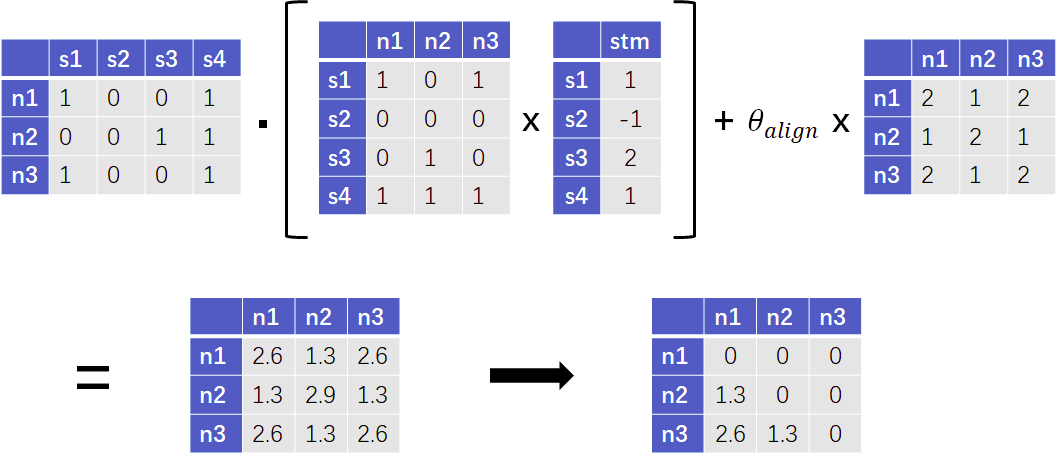

In [ ]:
def calculate_matrix(name_list, sentence_list, align_rate):
    '''
    Função que calcula a matriz de co-ocorrência e a matriz de sentimento entre os personagens mais relevantes 
    :param name_list: lista com os nomes dos maiores personagens
    :param sentence_list: lista com as frases no livro.
    :param align_rate: taxa de alinhamento sentimental
    :return: a matriz de co-occurrencia e a de sentimento.
    '''

    # calculate a sentiment score for each sentence in the novel
    afinn = Afinn()
    sentiment_score = [afinn.score(x) for x in sentence_list]
    # calculate occurrence matrix and sentiment matrix among the top characters
    name_vect = CountVectorizer(vocabulary=name_list, binary=True)
    occurrence_each_sentence = name_vect.fit_transform(sentence_list).toarray()
    cooccurrence_matrix = np.dot(occurrence_each_sentence.T, occurrence_each_sentence)
    sentiment_matrix = np.dot(occurrence_each_sentence.T, (occurrence_each_sentence.T * sentiment_score).T)
    sentiment_matrix += align_rate * cooccurrence_matrix
    cooccurrence_matrix = np.tril(cooccurrence_matrix)
    sentiment_matrix = np.tril(sentiment_matrix)
    # diagonals of the matrices are set to be 0 (co-occurrence of name itself is meaningless)
    shape = cooccurrence_matrix.shape[0]
    cooccurrence_matrix[[range(shape)], [range(shape)]] = 0
    sentiment_matrix[[range(shape)], [range(shape)]] = 0

    return cooccurrence_matrix, sentiment_matrix

#### Grafos de Co-Ocorrência e de Sentimento
Agora que temos as duas matrizes, podemos transformá-las nos parametros de um grafo e plotá-las. Para isso, primeiro **normalizamos** as matrizes para tornar a magnitude constante entre os diferentes livros, todavia mantendo a diversidade de personagens de um volume.

Em nosso **grafo de sentimento** da trilogia, cada **vértice** representa um personagem do romance e cada **aresta** representa o relacionamento entre ele e algum outro personagem do conjunto. Ainda, o tamanho de cada vértice corresponde a frequência de ocorrência do respectivo personagem.

Em relação a coloração dos arestas, que vai de claro (amarelo) a escuro (roxo), ela representa o **sentimento da relação** entre os dois personagens de forma mais humanamente compreensível: relação *hostil* ou *amigável*. Quanto mais *claro* um arco, mais *amigável* é aquela relação; quanto mais *escura* a cor, mais *hostil* é aquele relacionamento.

As funções `matrix_to_edge_list` e `plot_graph` apenas servem para deixar o plot mais alinhado passando os parâmetros adequados.

In [ ]:


def matrix_to_edge_list(matrix, mode, name_list):
    '''
    Function to convert matrix (co-occurrence/sentiment) to edge list of the network graph. It determines the
    weight and color of the edges in the network graph.
    :param matrix: co-occurrence matrix or sentiment matrix.
    :param mode: 'co-occurrence' or 'sentiment'
    :param name_list: the list of names of the top characters in the novel.
    :return: the edge list with weight and color param.
    '''
    edge_list = []
    shape = matrix.shape[0]
    lower_tri_loc = list(zip(*np.where(np.triu(np.ones([shape, shape])) == 0)))
    normalized_matrix = matrix / np.max(np.abs(matrix))
    if mode == 'co-occurrence':
        weight = np.log(2000 * normalized_matrix + 1) * 0.7
        color = np.log(2000 * normalized_matrix + 1)
    if mode == 'sentiment':
        weight = np.log(np.abs(1000 * normalized_matrix) + 1) * 0.7
        color = 2000 * normalized_matrix
    for i in lower_tri_loc:
        edge_list.append((name_list[i[0]], name_list[i[1]], {'weight': weight[i], 'color': color[i]}))

    return edge_list


def plot_graph(name_list, name_frequency, matrix, plt_name, mode, path=''):
    '''
    Function to plot the network graph (co-occurrence network or sentiment network).
    :param name_list: the list of top character names in the novel.
    :param name_frequency: the list containing the frequencies of the top names.
    :param matrix: co-occurrence matrix or sentiment matrix.
    :param plt_name: the name of the plot (PNG file) to output.
    :param mode: 'co-occurrence' or 'sentiment'
    :param path: the path to output the PNG file.
    :return: a PNG file of the network graph.
    '''

    label = {i: i for i in name_list}
    edge_list = matrix_to_edge_list(matrix, mode, name_list)
    normalized_frequency = np.array(name_frequency) / np.max(name_frequency)

    plt.figure(figsize=(20, 20))
    G = nx.Graph()
    G.add_nodes_from(name_list)
    G.add_edges_from(edge_list)
    pos = nx.circular_layout(G)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    colors = [G[u][v]['color'] for u, v in edges]

    if mode == 'co-occurrence':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000, edge_cmap=plt.cm.Blues,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True, width=weights)
    elif mode == 'sentiment':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True,
                width=weights, edge_vmin=-1000, edge_vmax=1000)
    else:
        raise ValueError("mode should be either 'co-occurrence' or 'sentiment'")

    plt.show()


## Rodando o modelo

In [ ]:
# Isso demora um bocado. Poderia ser feita uma implementação com processamento em paralelo para agilizar.

nlp = spacy.load('en_core_web_sm')
novel_list = ['https://github.com/chicodias/tolkien/raw/master/datasets/01%20-%20The%20Fellowship%20Of%20The%20Ring.txt', 
              'https://github.com/chicodias/tolkien/raw/master/datasets/02%20-%20The%20Two%20Towers.txt',
              'https://github.com/chicodias/tolkien/raw/master/datasets/03%20-%20The%20Return%20Of%20The%20King.txt']

## carrega as common words
words = common_words()
## le o livro
novel = read_novel(novel_list)
## carrega o livro em uma lista de sentenças e tokeniza
sentence_list = sent_tokenize(novel)
# calcula a taxa de alinhamento
align_rate = calculate_align_rate(sentence_list)
#lista preliminar de nomes
preliminary_name_list = iterative_NER(sentence_list)
# lista definitiva
name_frequency, name_list = top_names(preliminary_name_list, novel, 20)
# calcula as matrizes
cooccurrence_matrix, sentiment_matrix = calculate_matrix(name_list, sentence_list, align_rate)

### Grafos de co-ocorrência dos três livros

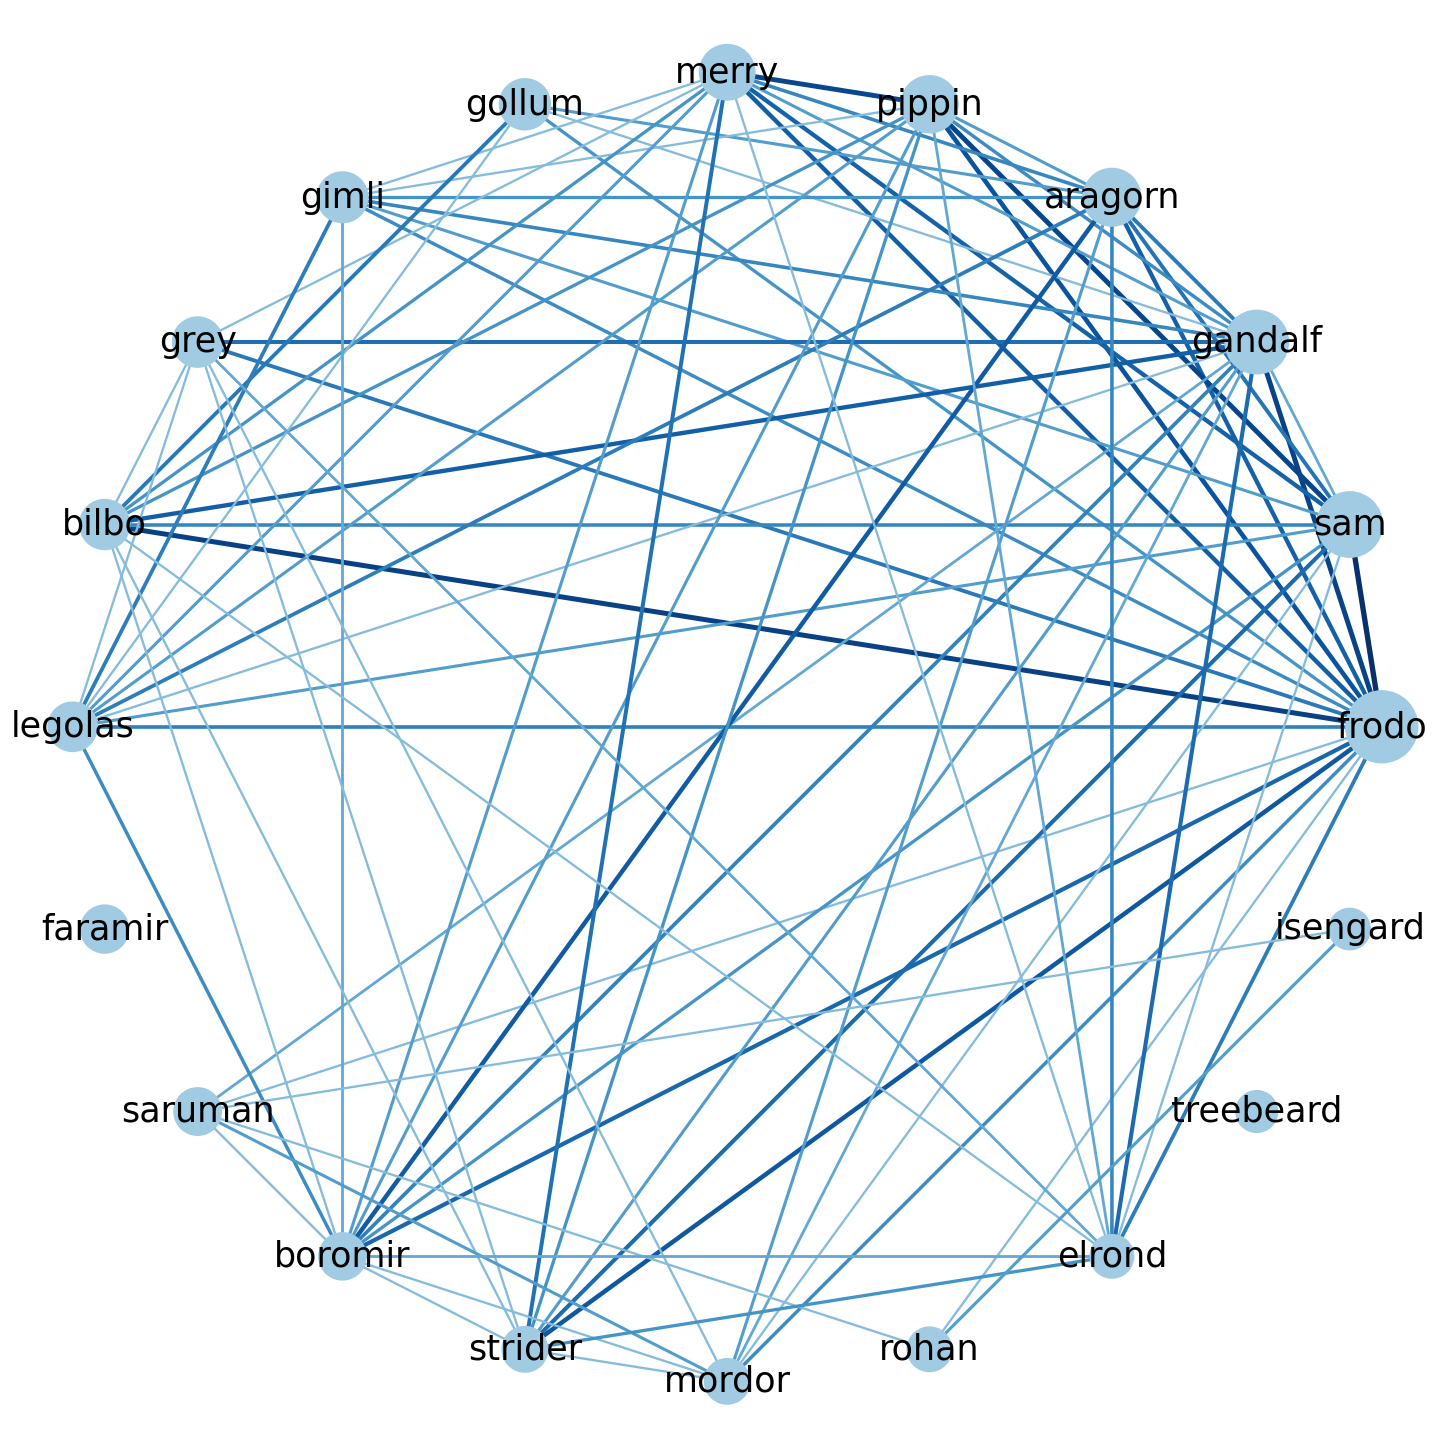

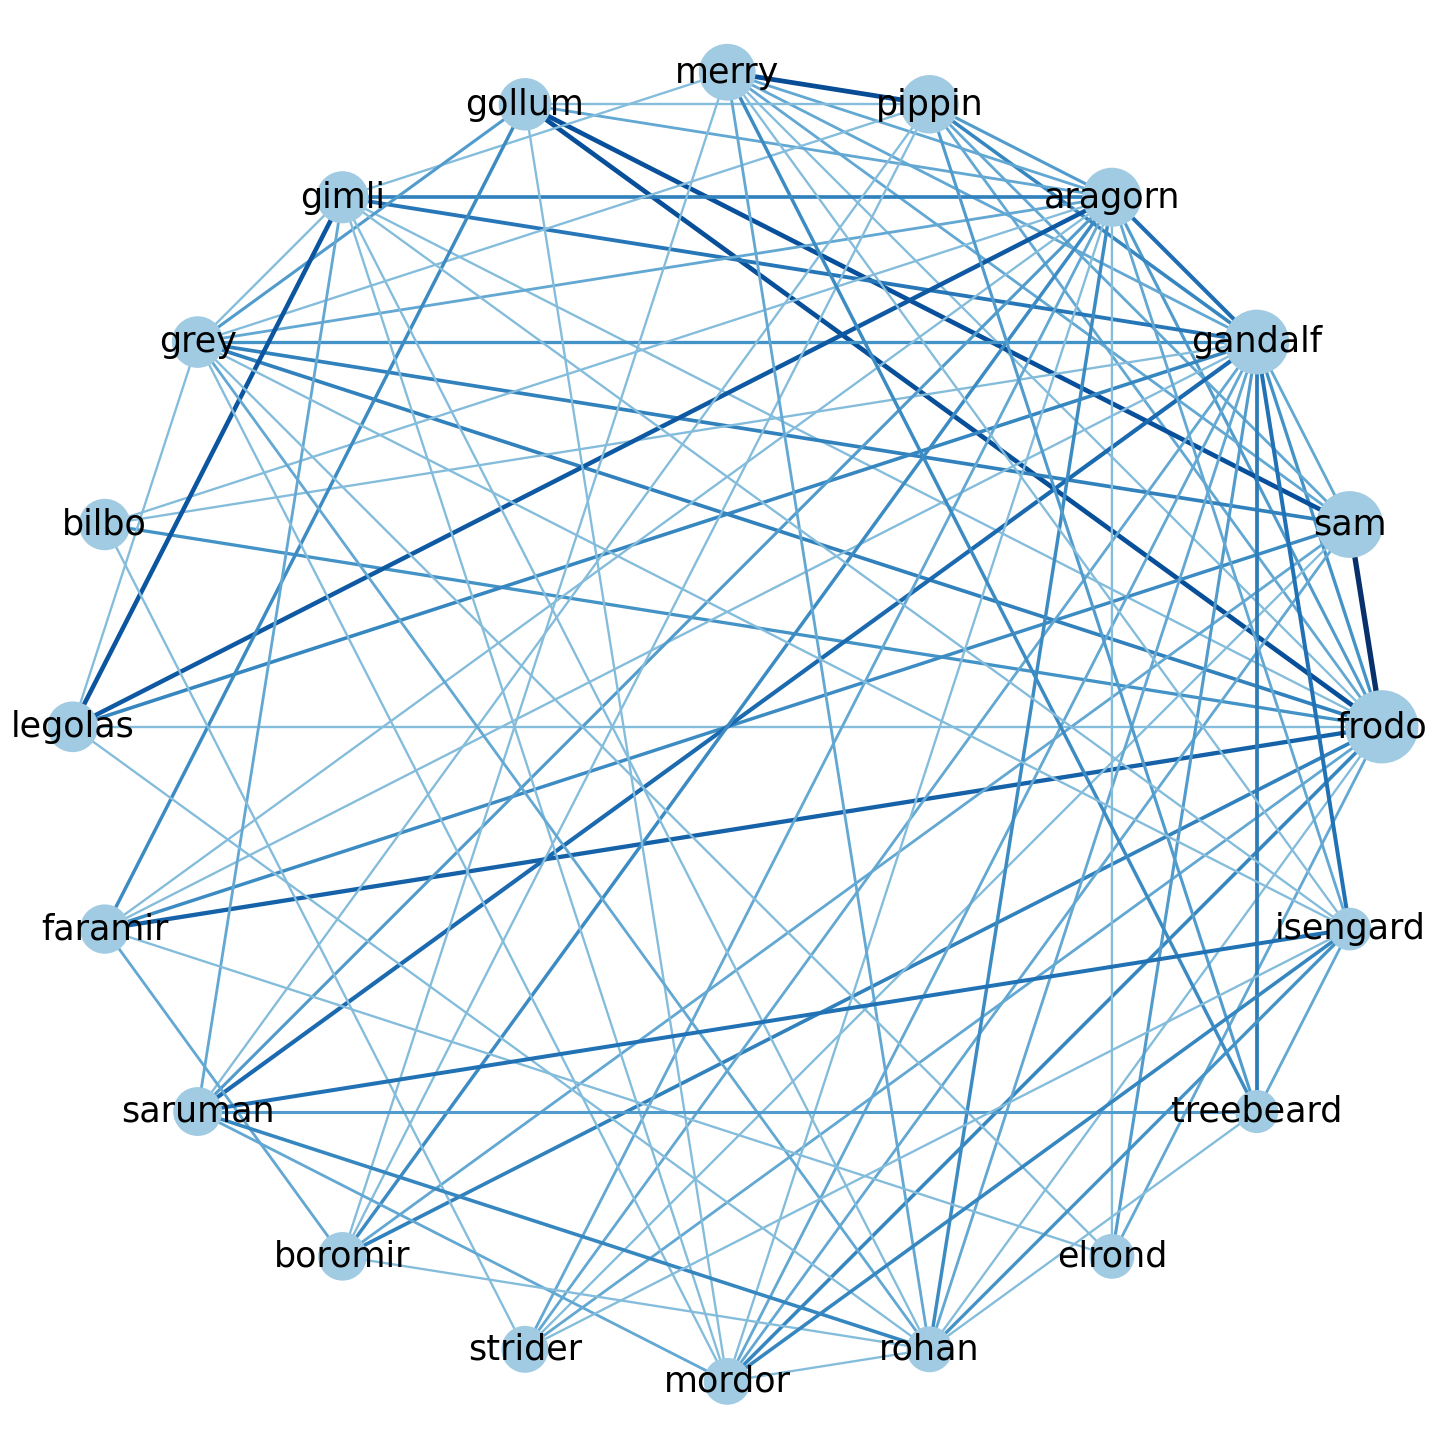

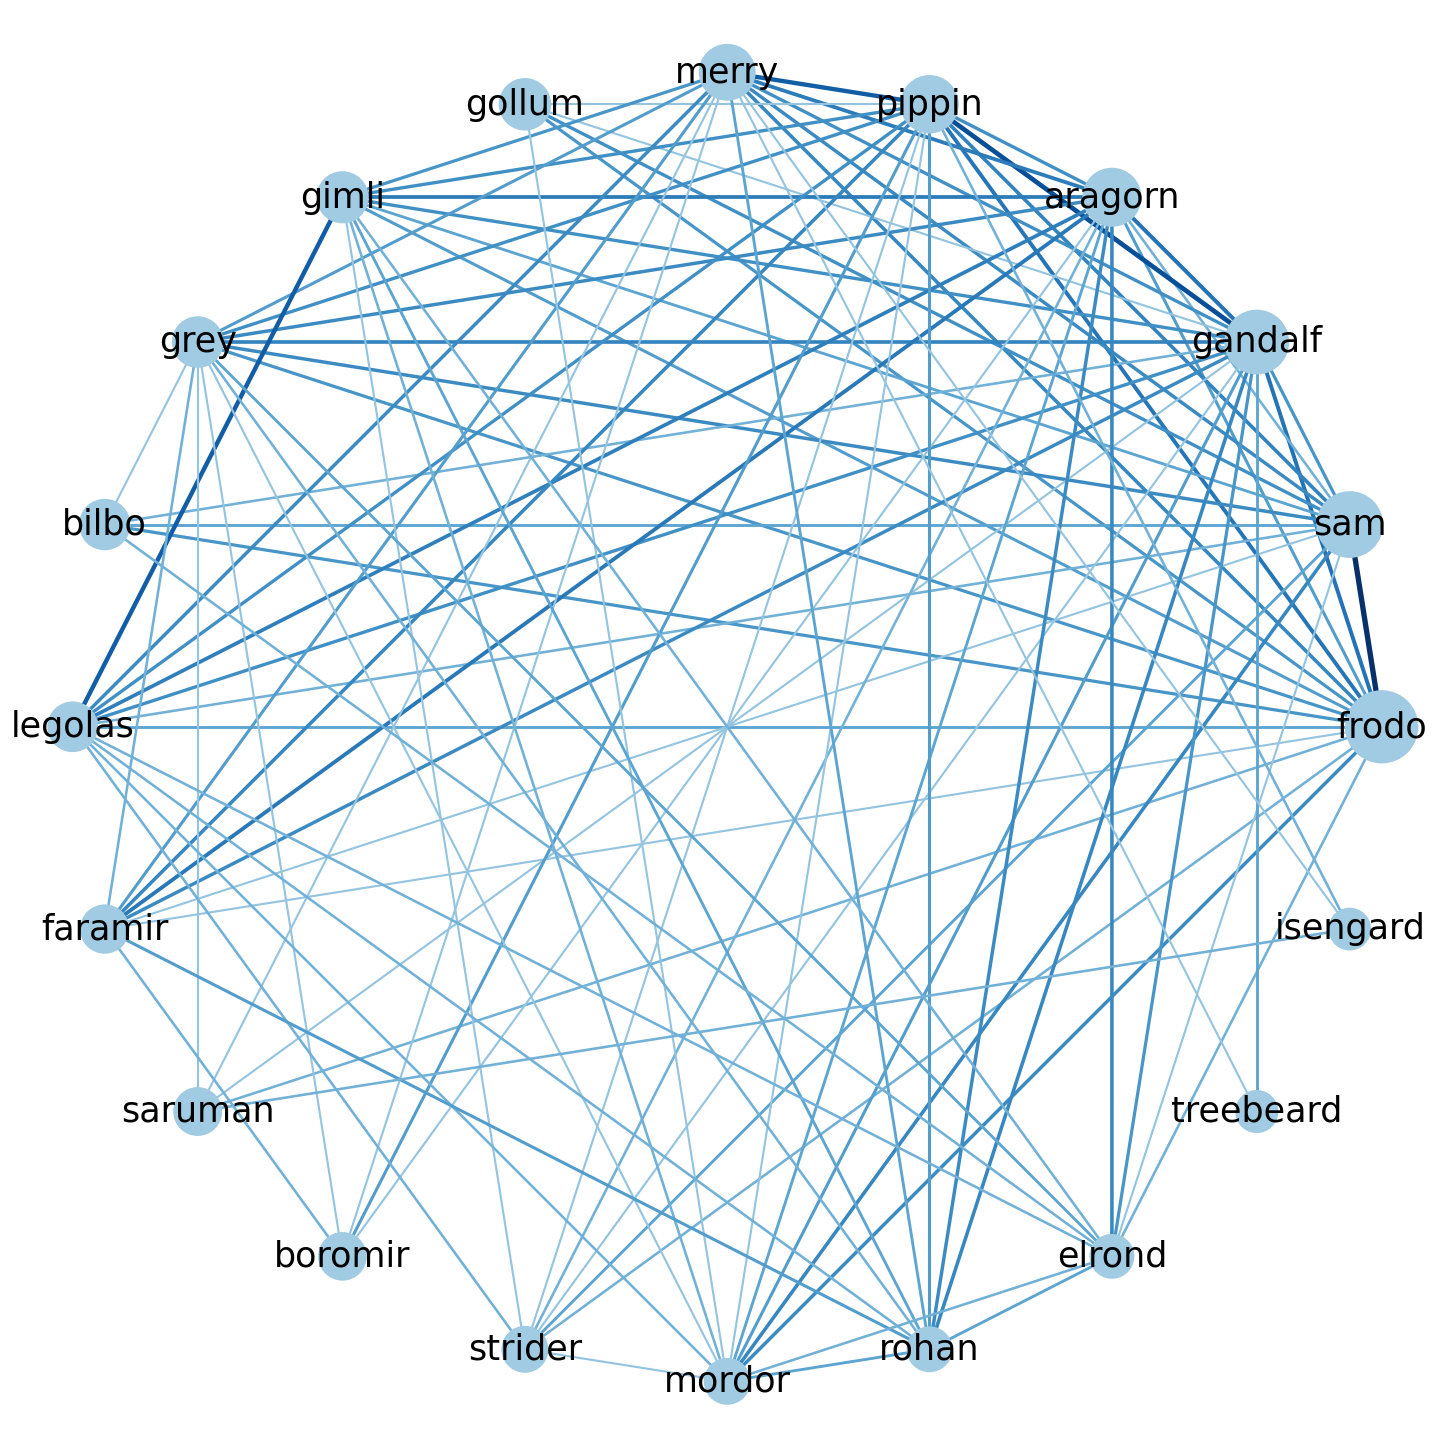

In [ ]:
for book in novel_list:
    name = "LoR"
    novel = read_novel([book])
    sentence_list = sent_tokenize(novel)
    cooccurrence_matrix, sentiment_matrix = calculate_matrix(name_list, sentence_list, align_rate)
    plot_graph(name_list, name_frequency, cooccurrence_matrix, name + ' co-occurrence graph', 'co-occurrence')


### Grafo de sentimento dos três livros

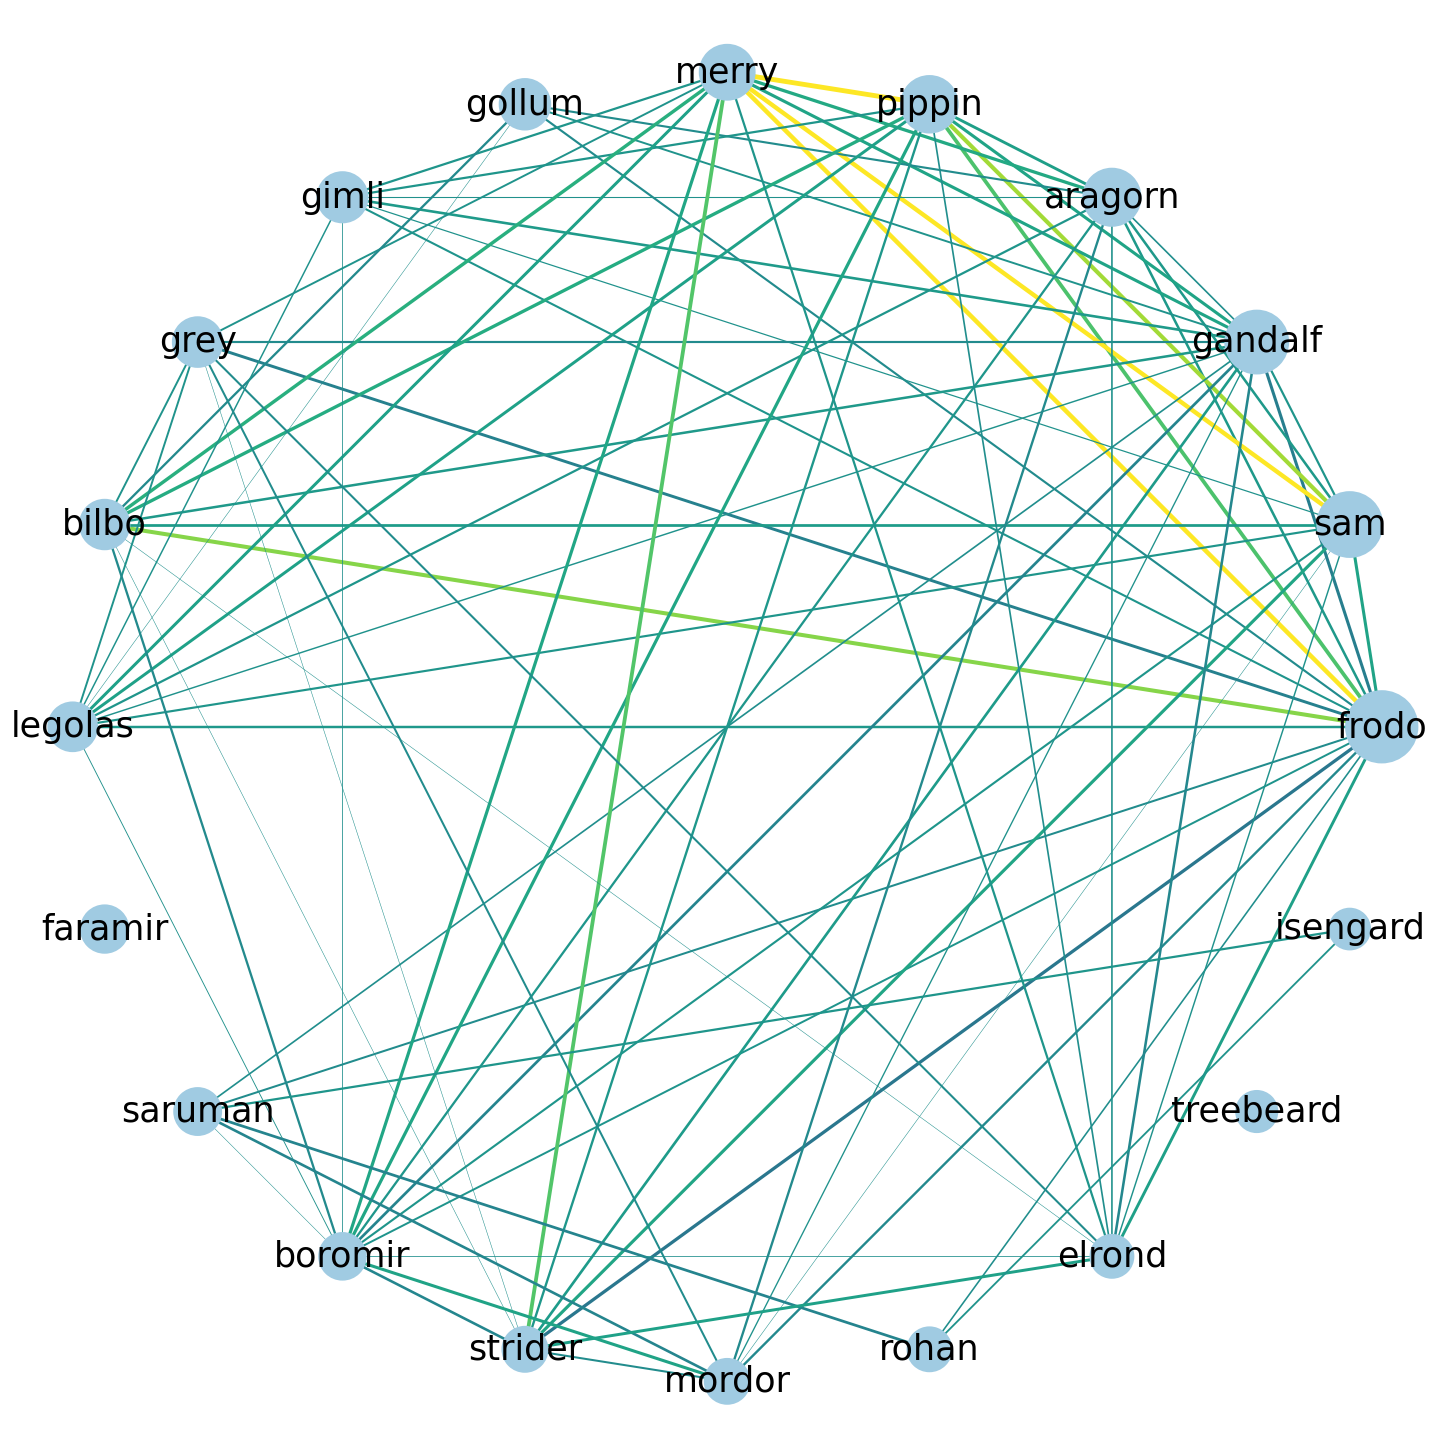

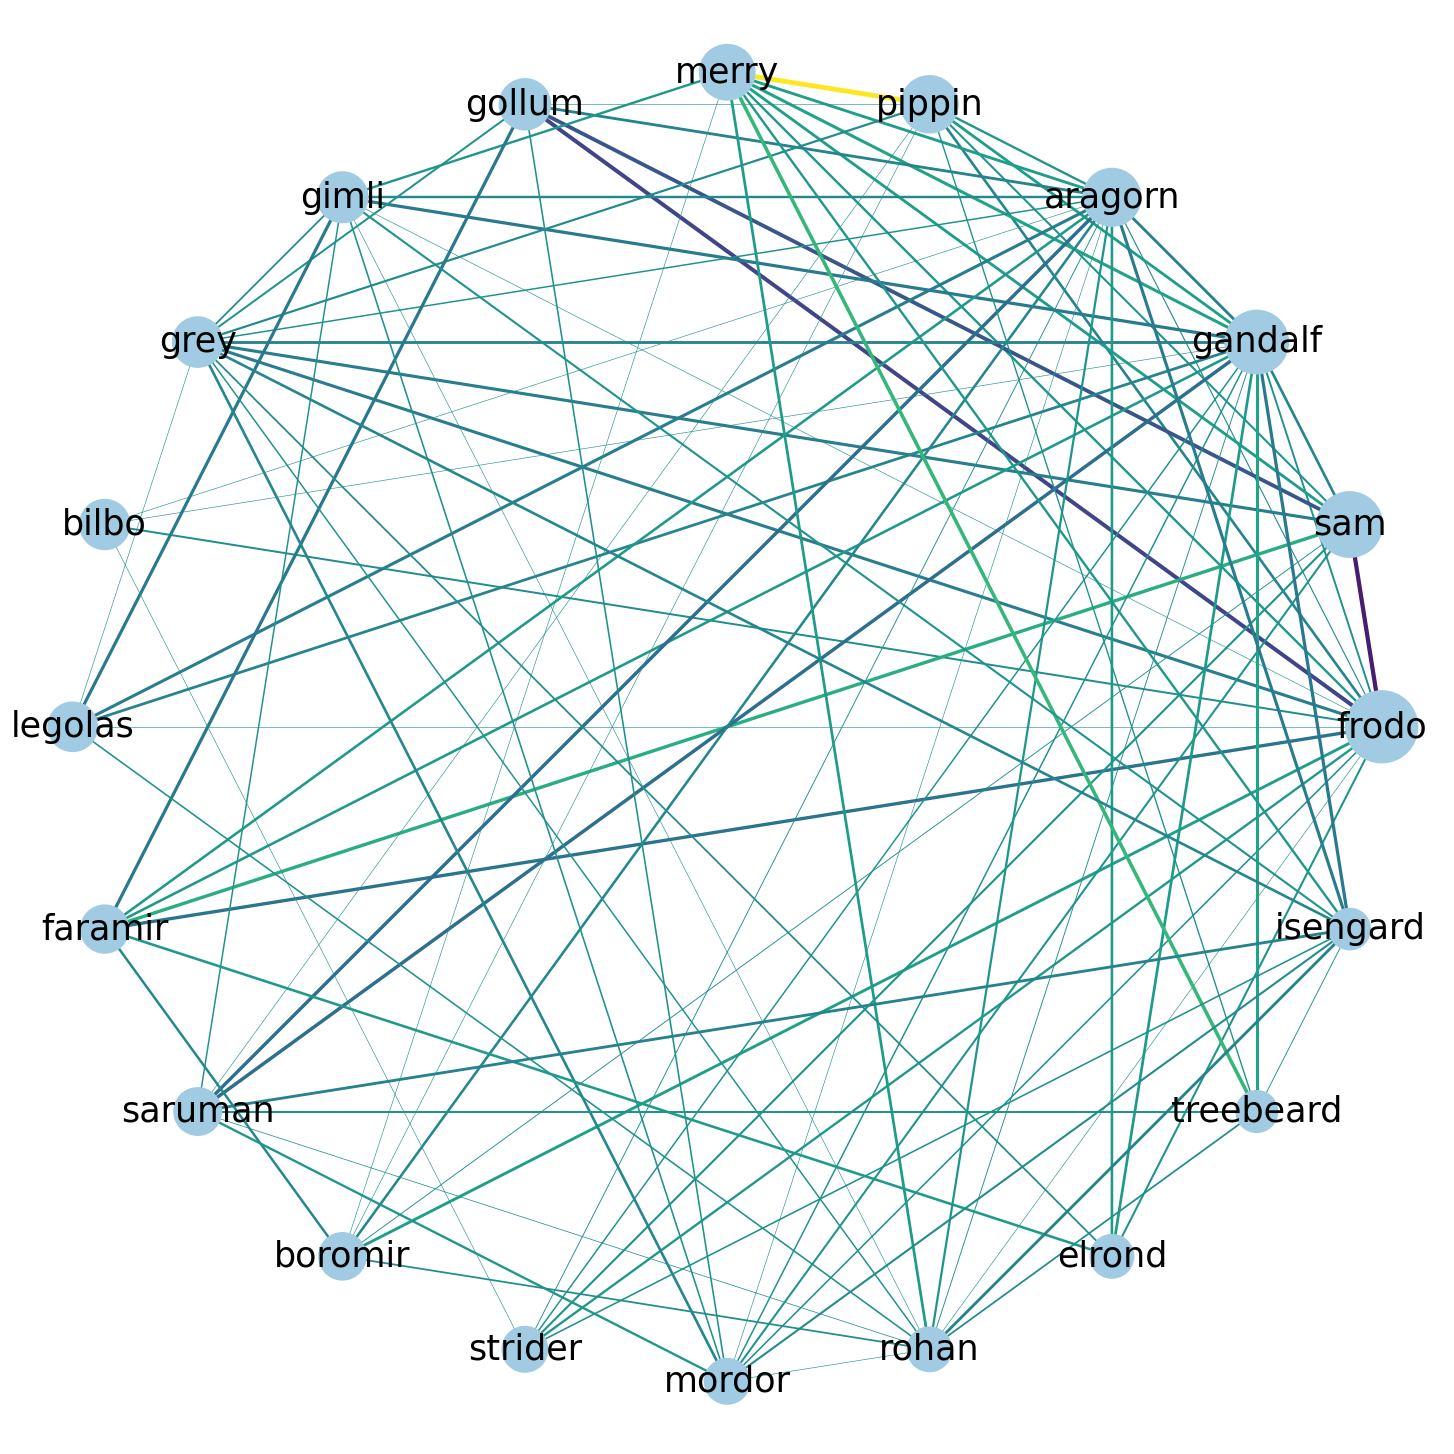

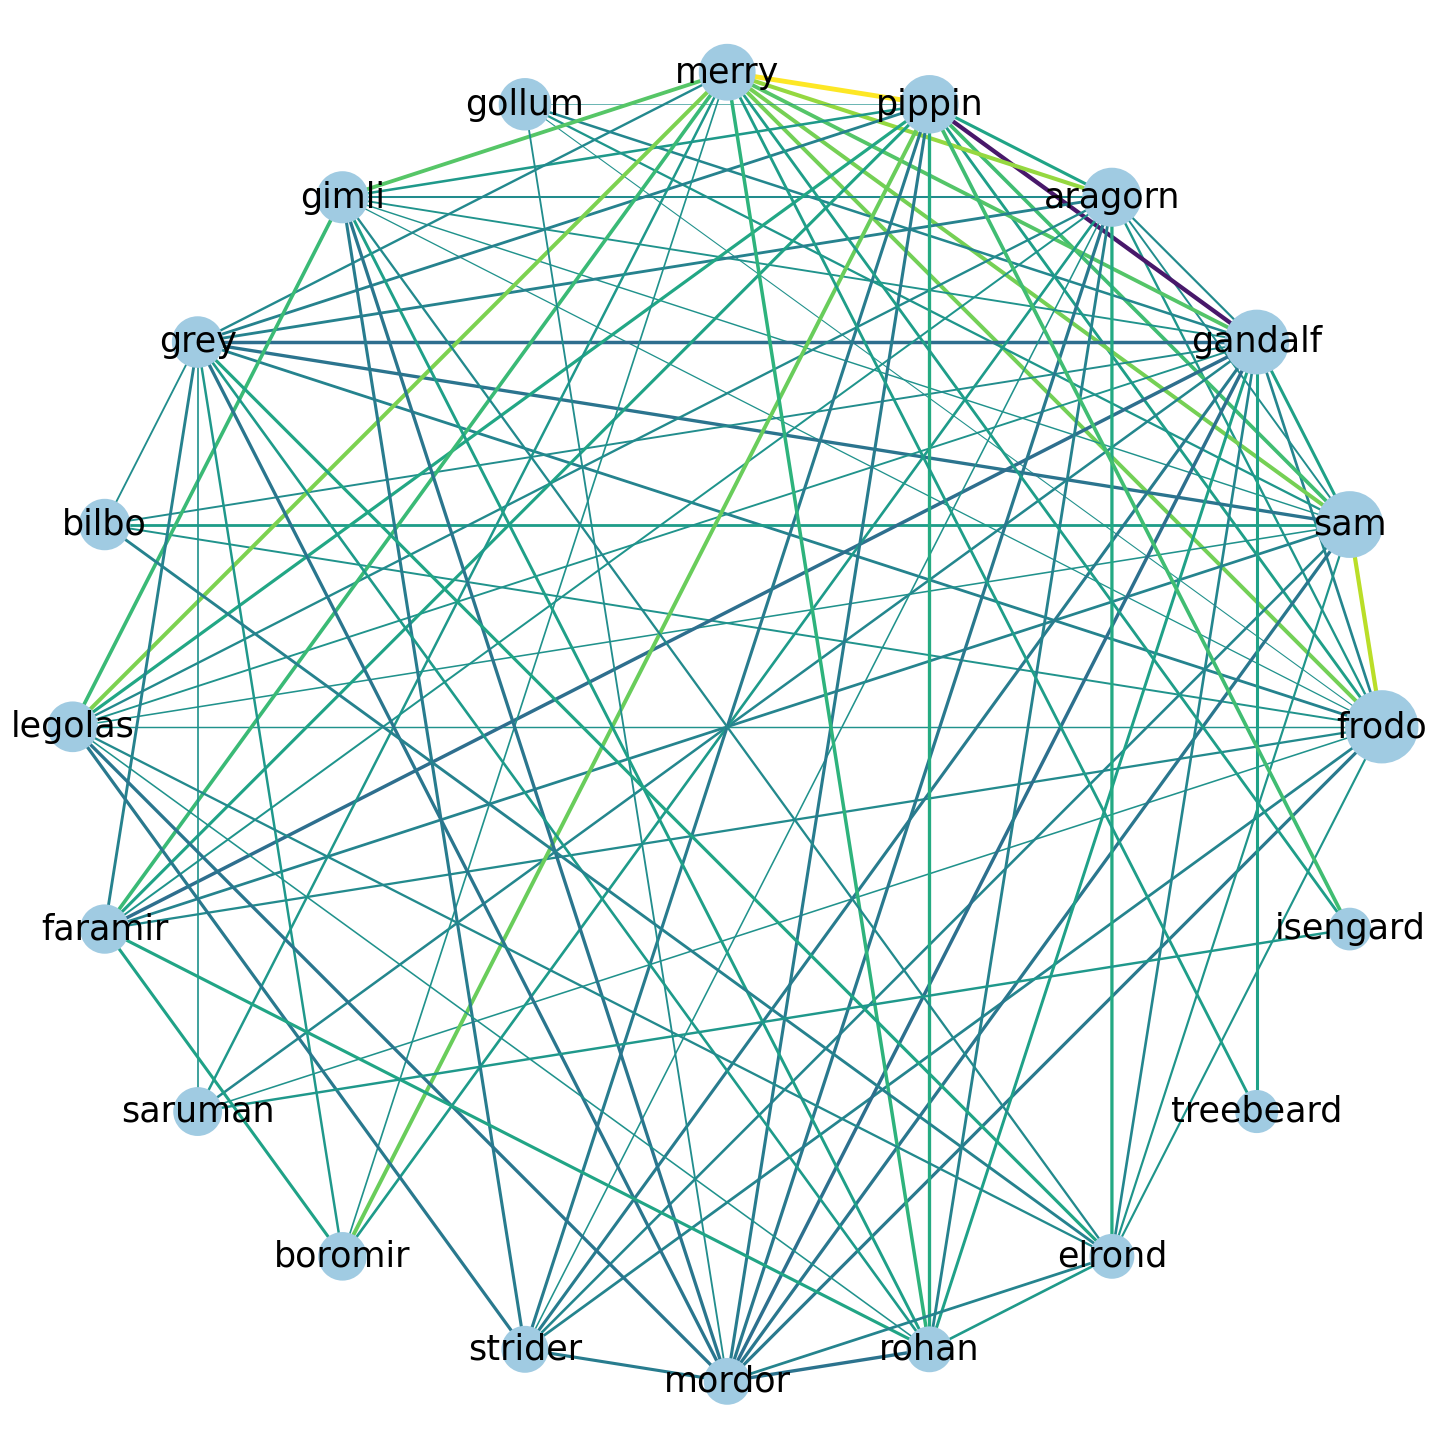

In [ ]:
for book in novel_list:
    novel = read_novel([book])
    sentence_list = sent_tokenize(novel)
    cooccurrence_matrix, sentiment_matrix = calculate_matrix(name_list, sentence_list, align_rate)
    plot_graph(name_list, name_frequency, sentiment_matrix, name + ' sentiment graph', 'sentiment')

## Insights proporcionados pela visualização

Como pudemos ver ao longo deste relatório, foi possível filtrar um conjunto de dados textual, que consistia em três livros, e, com o auxílio das funções de pré-processamento, ao final do processo obtivemos uma rede de entidades citadas ao longo do texto, sua respectiva co-ocorrência, além de sua respectiva análise sentimental. (É possível visualizar melhor as imagens [aqui](https://github.com/chicodias/character-network/tree/master/graphs)).

Como fãs da trilogia, foi um grande prazer observar as informações trazidas pelos grafos, e relacioná-las com o desenrolar da trama. Como pudemos constatar em nossa visualização, sem nenhuma surpresa Frodo, Sam, Gandalf e Aragorn eram os personagens mais mencionados no livro, conforme o grafo mostra. 

***Aviso***: contém spoilers sobre a trama

A co-ocorrência do primeiro volume dá-nos uma pista do porquê dele se chamar A Sociedade do Anel: a maior parte das co-ocorrências está relacionada com os membros da referida sociedade: Frodo, Sam, Gandalf, Aragorn, Pippin, Merry, Gmili, Legolas e Boromir, que são designados por Elrond.

Nesse momento da trama, o grafo de sentimentos nos mostra a relação amistosa entre os hobbits da sociedade (Frodo, Sam, Merry e Pippin); o personagem Gollum ainda não revelara-se, só sendo conhecido por histórias contadas de Bilbo para Frodo e de Gandalf para Aragorn.

A partir do segundo volume, as relações de co-ocorrência deixam de estar concentradas somente entre os membros da Sociedade do Anel: seus membros separam-se e cada um vive aventuras diferentes. Alguns exemplos da rede de co-ocorrência do segundo volume:

- Frodo e Sam encontram Gollum (um momento tenso da trama, os três possuem uma das relações mais hostis no respectivo grafo), e conhecem Faramir,
- Gmili, Aragorn e Legolas batalham em Rohan,
- Merry e Pippin lutam junto com Barbavore em Isengard,
- Gandalf é crucial para o desfecho dessas duas batalhas.

No terceiro e último volume, talvez os scores de sentimento sejam mais baixos justamente por boa parte dos envolvidos lutar a grande batalha da Guerra do Anel, exceto Sam, Frodo e Gollum. Juntos, os três conferem um desfecho à guerra, mas não no front.

### Grafo de co-ocorrência da trama inteira

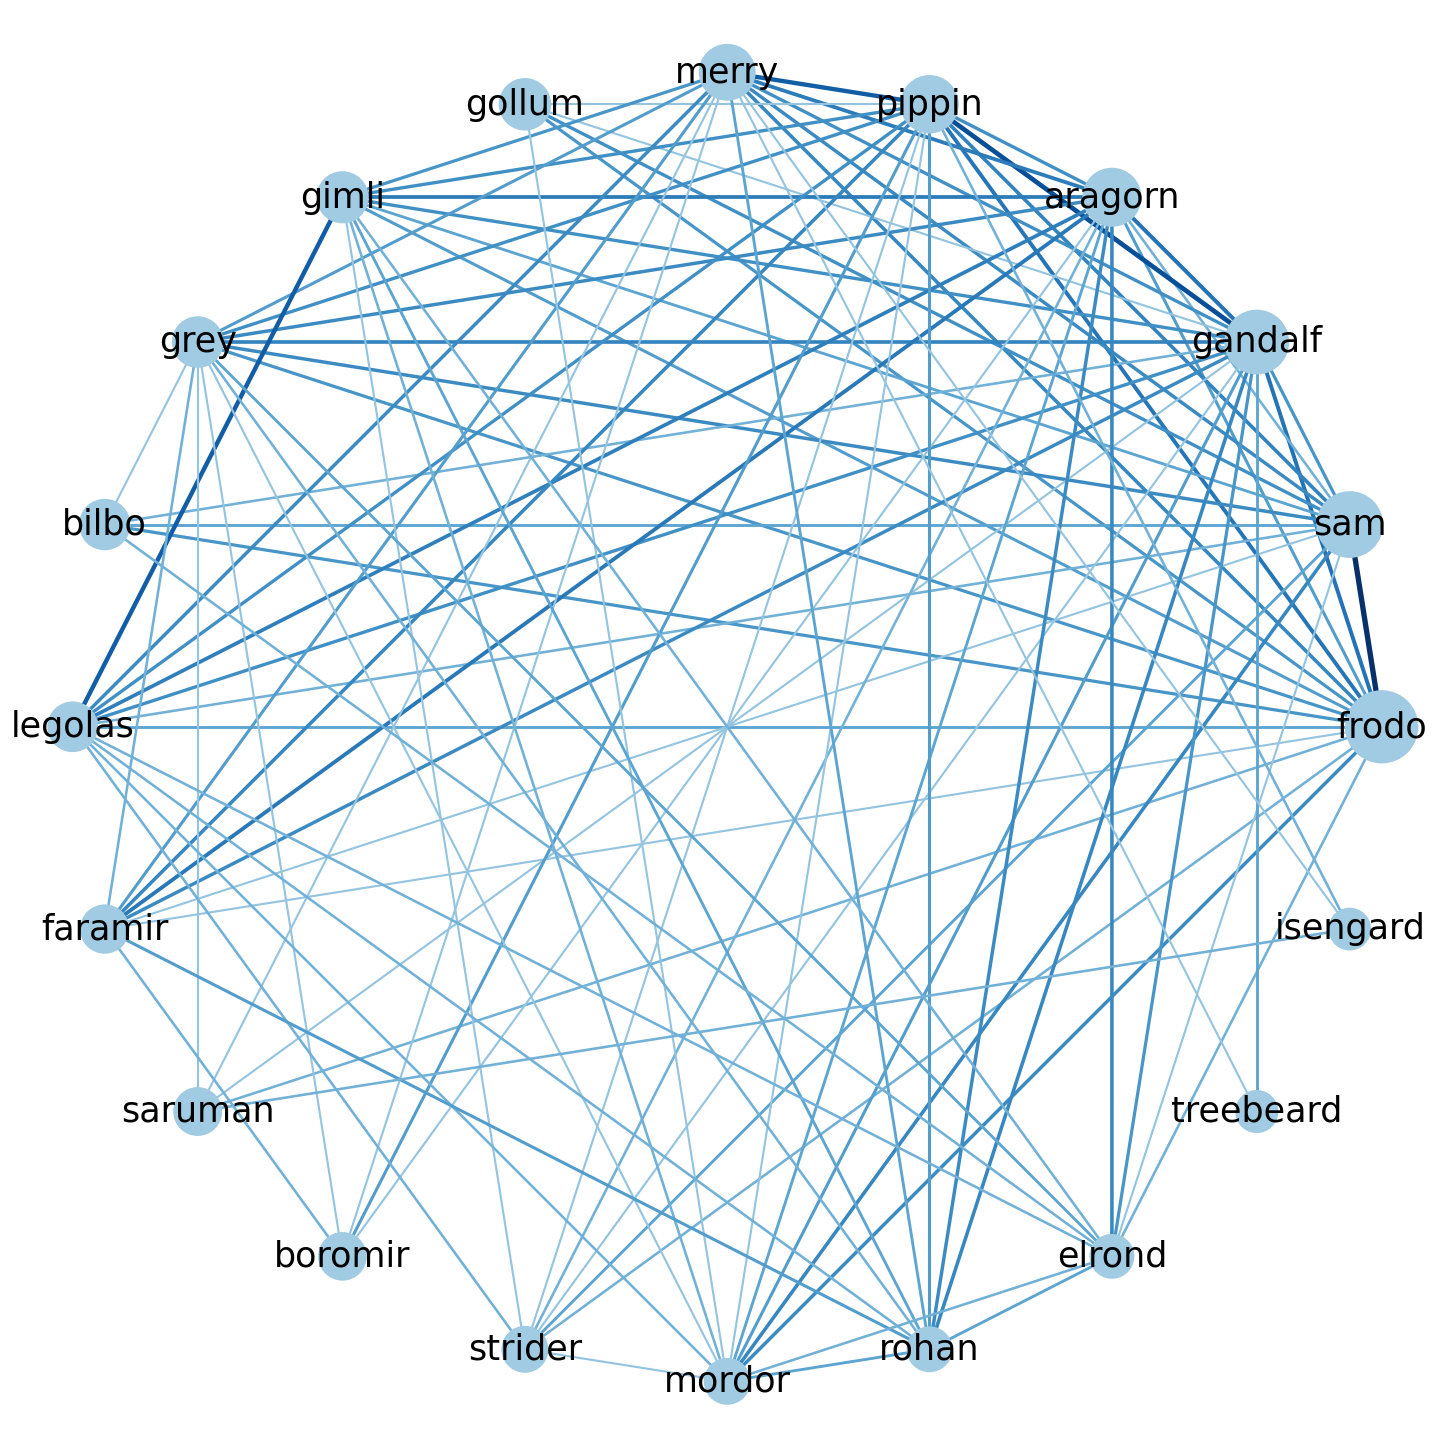

In [ ]:
##Grafo de co-ocorrência da trama inteira
plot_graph(name_list, name_frequency, cooccurrence_matrix, 'Toda a trama' + ' co-occurrence graph', 'co-occurrence')


### Grafo de sentimento da trama inteira

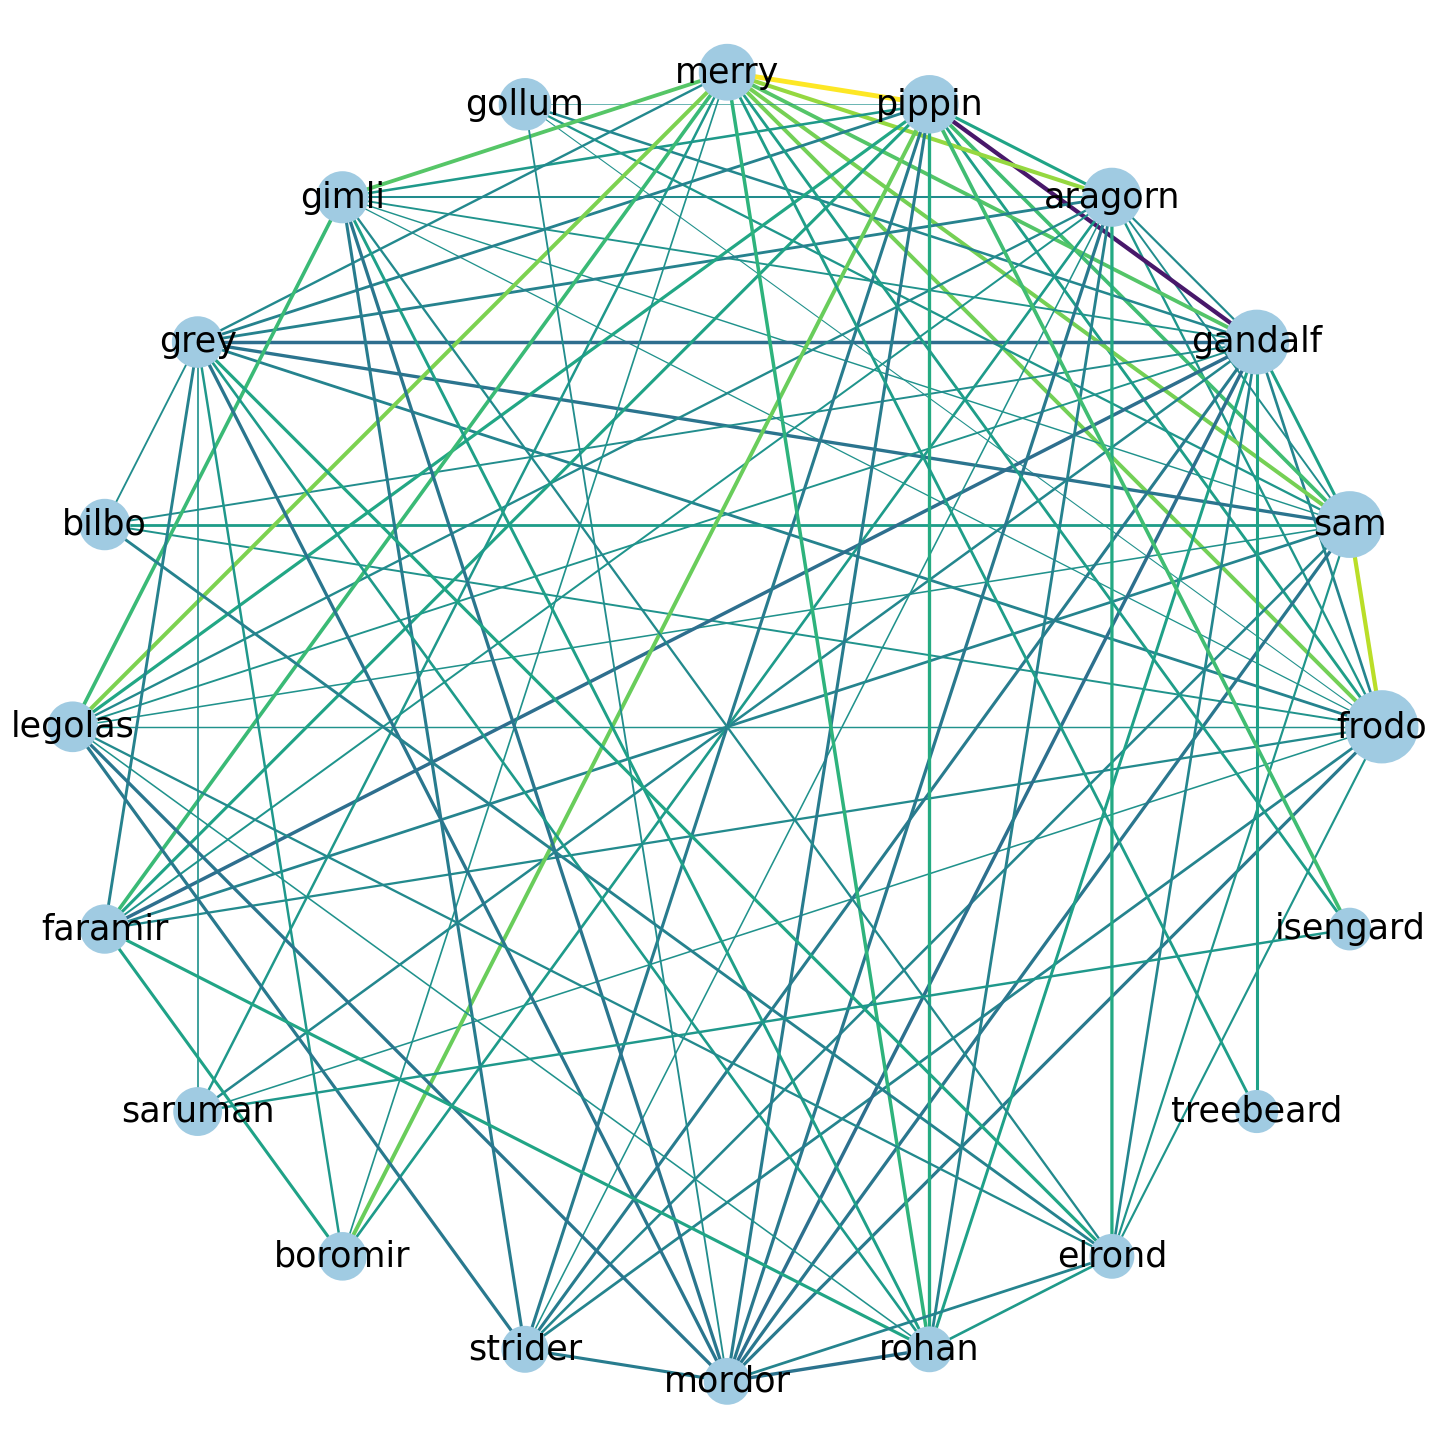

In [ ]:
## Grafo de sentimento da trama inteira
plot_graph(name_list, name_frequency, sentiment_matrix, 'Toda a trama' + ' sentiment graph', 'sentiment')

Para encerrar, Merry e Pippin parecem ser os que mais curtiram a jornada, eles têm um score de sentimento muito alto. Curiosamente, Pippin também possui o relacionamento mais hostil da trama inteira, com Gandalf. Pode ser que essa relação deva-se a uma célebre frase do mago: "Hobbit, seu tolo!"

## Conclusão

Neste trabalho, procuramos adotar um paradigma visual em nosso conjunto pré-processado de dados. Ao decorrer do processo, notamos que era necessário adotar outros passos em nosso pré-processamento, removendo as palavras mais comuns da língua inglesa para contribuir com a acurácia do nosso modelo de Entidade Mencionada.

Ao final do processo, nossos conjuntos de dados tornaram-se grafos, em que cada um dos vértices era um personagem, e as arestas a respectiva análise, de co-ocorrência ou sentimento, das relações em cada um dos livros. Com auxílio do catálogo data-to-viz, decidimos adotar o modelo de representação visual de grafos em rede.

Esse método tornou possível uma análise de redes complexas entre personagens que acontece em mais de mil páginas de romance, através de um programa que a gerou tendo como parâmetro de entrada somente os textos dos livros. Isso parecem ser boas notícias para "leitores preguiçosos", que gostam de pular partes da trama sem perder informação relevante do plot.

Como sugestão para próximos trabalhos, além do processamento paralelo poderíamos adotar um Modelo de Entidade que abrangesse também apelidos dos personagens (por exemplo, grey e Gandalf, strider e Aragorn são a mesma pessoa). Inclusive, um dos datasets utilizado no Trabalho 1 poderia contribuir incrivelmente para isso. Dessa forma, poderiam surgir outras relações não evidenciadas em nossos grafos.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("There came one day to Bilbo's door the great wizard, Gandalf the Grey.")

spacy.displacy.serve(doc, style='dep')


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

